# The LSTM Model Using Historical Data & Google Trends 
## Table of Contents

1. [Import Libraries](#Import_Libraries)
2. [Setup MLFlow Tracking](#MLFlow_Tracking)
3. [Load Data](#Load_Data)
4. [Pre-Process Data](#Pre_Processing)


5. Product Categories
   
   5.1 [Bed, Bath and Table](#bed_bath_table) 
   
   5.2 [Health and Beauty](#health_beauty)
   
   5.3 [Sports and Leisure](#sports_leisure)
   
   5.4 [Furniture Decor](#furniture_decor)
   
   5.5 [Watches and Gifts](#watches_gifts)
   
   5.6 [Telephony](#telephony)
   
   5.7 [Housewares](#housewares)

# Import Libraries <a name = "Import_Libraries"/>

In [1]:
import sys
import os
from utils import utils, metrics, dataset_2
import json
from pprint import pprint
import matplotlib.pyplot as plt
plt.style.use('bmh')
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn import preprocessing
import mlflow

# Setup MLFlow Tracking <a name = "MLFlow_Tracking"/>
https://www.mlflow.org/docs/latest/tracking.html

In [2]:
# If this is the first time running the notebook, uncomment next line.
#This is to create a file called mlruns which will store the logs for each time the notebook is run

#mlflow_experiment_id = mlflow.create_experiment('Olist_LSTM_GoogleTrends_MLFlow')

#else:
mlflow.set_experiment('Olist_LSTM_GoogleTrends_MLFlow')
client = mlflow.tracking.MlflowClient()
# See ui 
#!mlflow ui

# Load Data <a name = "Load_Data"/>

In [3]:
# Read Config file
config = "configs_LSTM_GoogleTrends.json"

try:
    with open(config, "r") as f:
        config = json.load(f)
        print('\033[92m','Load successfull. config = \n')
        pprint(config)
except:
    raise IOError(f"Impossible to read config file: {config}")

 Load successfull. config = 

{'dates': {'test_end': '2017-12-14',
           'test_start': '2017-12-1',
           'train_start': '2017-07-01',
           'valid_start': '2017-11-21'},
 'directories': {'base_dir': 'brazilian-ecommerce'},
 'drop_date': False,
 'end_date': '2017-12-31 23:59:59',
 'pre_processing': {'add_date_features': False,
                    'col_name': 'payment_value',
                    'impute_nan': 'zero',
                    'prefix_name': 'lag',
                    'window_size': 55},
 'product_categories': ['bed_bath_table',
                        'health_beauty',
                        'sports_leisure',
                        'furniture_decor',
                        'computer_accessories',
                        'housewares',
                        'watches_gifts',
                        'telephony',
                        'garden_tools',
                        'auto'],
 'rm_product_category': False,
 'start_date': '2016-11-01 00:00:00',
 'state':

# Pre-Process Training, Validation and Test Datasets <a name = "Pre_Processing"/>

In [4]:
df_train, df_valid, df_test = dataset_2.make_dataset(config)
# re-sort columns from last to current and drop the first days
df_train = df_train[df_train.columns[::-1]].dropna()
df_valid = df_valid[df_valid.columns[::-1]]
df_test = df_test[df_test.columns[::-1]]

In [5]:
from sklearn.base import BaseEstimator

class MinMaxScalerDf(BaseEstimator):
    "Scale the whole data, not just one column using the min and max values."
    def __init__(self):
        pass
    
    def fit_transform(self, tensor_3d):
        self.min_ = tensor_3d.min()
        self.max_ = tensor_3d.max()
        
        return (tensor_3d - self.min_) / (self.max_ - self.min_)
        
    def transform(self, tensor_3d):
        return (tensor_3d - self.min_) / (self.max_ - self.min_)
    
    def inverse_transform(self, tensor_3d):
        return (tensor_3d + self.min_) * (self.max_ + self.min_)

# Product Category 1: Bed, Bath and Table <a name = "bed_bath_table"/>

In [6]:
#Filter on product categories (series)
bed_bath_table_train = df_train.loc[df_train['product_category_name'] == 'bed_bath_table'].copy()
bed_bath_table_valid = df_valid.loc[df_valid['product_category_name'] == 'bed_bath_table'].copy()
bed_bath_table_test = df_test.loc[df_test['product_category_name'] == 'bed_bath_table'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

bed_bath_table_train.drop(columns, inplace=True, axis=1)
bed_bath_table_valid.drop(columns, inplace=True, axis=1)
bed_bath_table_test.drop(columns, inplace=True, axis=1)

In [7]:
#Read and process GoogleTrends Series
base_dir_1 = "C:\\Users\\feras\\Documents\\Thesis_2020\\GoogleTrendsSeries\\"

cama = pd.read_csv(os.path.join(base_dir_1,'Cama_Shopping.csv')).iloc[1:]
mesa = pd.read_csv(os.path.join(base_dir_1,'Mesa_Shopping.csv')).iloc[1:]
banho = pd.read_csv(os.path.join(base_dir_1,'Banho_Shopping.csv')).iloc[1:]
bed_bath_topic = pd.read_csv(os.path.join(base_dir_1,'Bed_Bath_Topic.csv')).iloc[1:]


cama_gt =  utils.make_lag_features(cama,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Shopping', 
                                   prefix_name='cama_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})

mesa_gt =  utils.make_lag_features(mesa,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Shopping', 
                                   prefix_name='mesa_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})

banho_gt =  utils.make_lag_features(banho,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Shopping', 
                                   prefix_name='banho_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})


bed_bath_topic_gt =  utils.make_lag_features(bed_bath_topic,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Bed & Bath', 
                                   prefix_name='bed_bath_topic_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})


# we dont care about the prediction here. Drop category
cama_gt.drop(columns='Category: Shopping', inplace=True)
cama_gt = cama_gt[cama_gt.columns[::-1]]

mesa_gt.drop(columns='Category: Shopping', inplace=True)
mesa_gt = mesa_gt[mesa_gt.columns[::-1]]

banho_gt.drop(columns='Category: Shopping', inplace=True)
banho_gt = banho_gt[banho_gt.columns[::-1]]

bed_bath_topic_gt.drop(columns='Category: Bed & Bath', inplace=True)
bed_bath_topic_gt = bed_bath_topic_gt[bed_bath_topic_gt.columns[::-1]]

In [8]:
# Filter HistoricalSales and GoogleTrends Series

cama_gt['order_approved_at'] = pd.to_datetime(cama_gt['order_approved_at'])

bed_bath_table_train = bed_bath_table_train[(bed_bath_table_train['order_approved_at'] >= cama_gt['order_approved_at'].min()) &
                    (bed_bath_table_train['order_approved_at'] < cama_gt['order_approved_at'].max())]

bed_bath_table_valid = bed_bath_table_valid[(bed_bath_table_valid['order_approved_at'] >= cama_gt['order_approved_at'].min()) &
                    (bed_bath_table_valid['order_approved_at'] < cama_gt['order_approved_at'].max())]

bed_bath_table_test = bed_bath_table_test[(bed_bath_table_test['order_approved_at'] >= cama_gt['order_approved_at'].min()) &
                  (bed_bath_table_test['order_approved_at'] < cama_gt['order_approved_at'].max())]

cama_gt_train = cama_gt[(cama_gt['order_approved_at'] >= bed_bath_table_train['order_approved_at'].min()) &
                                           (cama_gt['order_approved_at'] <= bed_bath_table_train['order_approved_at'].max())].copy()
cama_gt_valid = cama_gt[(cama_gt['order_approved_at'] >= bed_bath_table_valid['order_approved_at'].min()) &
                                           (cama_gt['order_approved_at'] <= bed_bath_table_valid['order_approved_at'].max())].copy()
cama_gt_test = cama_gt[(cama_gt['order_approved_at'] >= bed_bath_table_test['order_approved_at'].min()) &
                                           (cama_gt['order_approved_at'] <= bed_bath_table_test['order_approved_at'].max())].copy()


mesa_gt['order_approved_at'] = pd.to_datetime(mesa_gt['order_approved_at'])

bed_bath_table_train = bed_bath_table_train[(bed_bath_table_train['order_approved_at'] >= mesa_gt['order_approved_at'].min()) &
                    (bed_bath_table_train['order_approved_at'] < mesa_gt['order_approved_at'].max())]

bed_bath_table_valid = bed_bath_table_valid[(bed_bath_table_valid['order_approved_at'] >= mesa_gt['order_approved_at'].min()) &
                    (bed_bath_table_valid['order_approved_at'] < mesa_gt['order_approved_at'].max())]

bed_bath_table_test = bed_bath_table_test[(bed_bath_table_test['order_approved_at'] >= mesa_gt['order_approved_at'].min()) &
                  (bed_bath_table_test['order_approved_at'] < mesa_gt['order_approved_at'].max())]

mesa_gt_train = mesa_gt[(mesa_gt['order_approved_at'] >= bed_bath_table_train['order_approved_at'].min()) &
                                           (mesa_gt['order_approved_at'] <= bed_bath_table_train['order_approved_at'].max())].copy()
mesa_gt_valid = mesa_gt[(mesa_gt['order_approved_at'] >= bed_bath_table_valid['order_approved_at'].min()) &
                                           (mesa_gt['order_approved_at'] <= bed_bath_table_valid['order_approved_at'].max())].copy()
mesa_gt_test = mesa_gt[(mesa_gt['order_approved_at'] >= bed_bath_table_test['order_approved_at'].min()) &
                                           (mesa_gt['order_approved_at'] <= bed_bath_table_test['order_approved_at'].max())].copy()


banho_gt['order_approved_at'] = pd.to_datetime(banho_gt['order_approved_at'])

bed_bath_table_train = bed_bath_table_train[(bed_bath_table_train['order_approved_at'] >= banho_gt['order_approved_at'].min()) &
                    (bed_bath_table_train['order_approved_at'] < banho_gt['order_approved_at'].max())]

bed_bath_table_valid = bed_bath_table_valid[(bed_bath_table_valid['order_approved_at'] >= banho_gt['order_approved_at'].min()) &
                    (bed_bath_table_valid['order_approved_at'] < banho_gt['order_approved_at'].max())]

bed_bath_table_test = bed_bath_table_test[(bed_bath_table_test['order_approved_at'] >= banho_gt['order_approved_at'].min()) &
                  (bed_bath_table_test['order_approved_at'] < banho_gt['order_approved_at'].max())]

banho_gt_train = banho_gt[(banho_gt['order_approved_at'] >= bed_bath_table_train['order_approved_at'].min()) &
                                           (banho_gt['order_approved_at'] <= bed_bath_table_train['order_approved_at'].max())].copy()
banho_gt_valid = banho_gt[(banho_gt['order_approved_at'] >= bed_bath_table_valid['order_approved_at'].min()) &
                                           (banho_gt['order_approved_at'] <= bed_bath_table_valid['order_approved_at'].max())].copy()
banho_gt_test = banho_gt[(banho_gt['order_approved_at'] >= bed_bath_table_test['order_approved_at'].min()) &
                                           (banho_gt['order_approved_at'] <= bed_bath_table_test['order_approved_at'].max())].copy()

bed_bath_topic_gt['order_approved_at'] = pd.to_datetime(bed_bath_topic_gt['order_approved_at'])

bed_bath_table_train = bed_bath_table_train[(bed_bath_table_train['order_approved_at'] >= bed_bath_topic_gt['order_approved_at'].min()) &
                    (bed_bath_table_train['order_approved_at'] < bed_bath_topic_gt['order_approved_at'].max())]

bed_bath_table_valid = bed_bath_table_valid[(bed_bath_table_valid['order_approved_at'] >= bed_bath_topic_gt['order_approved_at'].min()) &
                    (bed_bath_table_valid['order_approved_at'] < bed_bath_topic_gt['order_approved_at'].max())]

bed_bath_table_test = bed_bath_table_test[(bed_bath_table_test['order_approved_at'] >= bed_bath_topic_gt['order_approved_at'].min()) &
                  (bed_bath_table_test['order_approved_at'] < bed_bath_topic_gt['order_approved_at'].max())]

bed_bath_topic_gt_train = bed_bath_topic_gt[(bed_bath_topic_gt['order_approved_at'] >= bed_bath_table_train['order_approved_at'].min()) &
                                           (bed_bath_topic_gt['order_approved_at'] <= bed_bath_table_train['order_approved_at'].max())].copy()
bed_bath_topic_gt_valid = bed_bath_topic_gt[(bed_bath_topic_gt['order_approved_at'] >= bed_bath_table_valid['order_approved_at'].min()) &
                                           (bed_bath_topic_gt['order_approved_at'] <= bed_bath_table_valid['order_approved_at'].max())].copy()
bed_bath_topic_gt_test = bed_bath_topic_gt[(bed_bath_topic_gt['order_approved_at'] >= bed_bath_table_test['order_approved_at'].min()) &
                                           (bed_bath_topic_gt['order_approved_at'] <= bed_bath_table_test['order_approved_at'].max())].copy()


In [9]:
# Drop unrequired columns
bed_bath_table_train = bed_bath_table_train.drop(columns=['order_approved_at'])
bed_bath_table_valid = bed_bath_table_valid.drop(columns=['order_approved_at'])
bed_bath_table_test = bed_bath_table_test.drop(columns=['order_approved_at'])

cama_gt_train = cama_gt_train.drop(columns=['order_approved_at'])
cama_gt_valid = cama_gt_valid.drop(columns=['order_approved_at'])
cama_gt_test = cama_gt_test.drop(columns=['order_approved_at'])

mesa_gt_train = mesa_gt_train.drop(columns=['order_approved_at'])
mesa_gt_valid = mesa_gt_valid.drop(columns=['order_approved_at'])
mesa_gt_test = mesa_gt_test.drop(columns=['order_approved_at'])

banho_gt_train = banho_gt_train.drop(columns=['order_approved_at'])
banho_gt_valid = banho_gt_valid.drop(columns=['order_approved_at'])
banho_gt_test = banho_gt_test.drop(columns=['order_approved_at'])

bed_bath_topic_gt_train = bed_bath_topic_gt_train.drop(columns=['order_approved_at'])
bed_bath_topic_gt_valid = bed_bath_topic_gt_valid.drop(columns=['order_approved_at'])
bed_bath_topic_gt_test = bed_bath_topic_gt_test.drop(columns=['order_approved_at'])

In [10]:
# Reshape and convert to numpy arrays
bed_bath_table_train = bed_bath_table_train.to_numpy().reshape(bed_bath_table_train.shape[0], bed_bath_table_train.shape[1], 1)
bed_bath_table_valid = bed_bath_table_valid.to_numpy().reshape(bed_bath_table_valid.shape[0], bed_bath_table_valid.shape[1], 1)
bed_bath_table_test = bed_bath_table_test.to_numpy().reshape(bed_bath_table_test.shape[0], bed_bath_table_test.shape[1], 1)

cama_gt_train = cama_gt_train.astype(int).to_numpy().reshape(cama_gt_train.shape[0], 
                                                                               cama_gt_train.shape[1], 1)
cama_gt_valid = cama_gt_valid.astype(int).to_numpy().reshape(cama_gt_valid.shape[0], 
                                                                               cama_gt_valid.shape[1], 1)
cama_gt_test = cama_gt_test.astype(int).to_numpy().reshape(cama_gt_test.shape[0], 
                                                                             cama_gt_test.shape[1], 1)


mesa_gt_train = mesa_gt_train.astype(int).to_numpy().reshape(mesa_gt_train.shape[0], 
                                                                               mesa_gt_train.shape[1], 1)
mesa_gt_valid = mesa_gt_valid.astype(int).to_numpy().reshape(mesa_gt_valid.shape[0], 
                                                                               mesa_gt_valid.shape[1], 1)
mesa_gt_test = mesa_gt_test.astype(int).to_numpy().reshape(mesa_gt_test.shape[0], 
                                                                             mesa_gt_test.shape[1], 1)

banho_gt_train = banho_gt_train.astype(int).to_numpy().reshape(banho_gt_train.shape[0], 
                                                                               banho_gt_train.shape[1], 1)
banho_gt_valid = banho_gt_valid.astype(int).to_numpy().reshape(banho_gt_valid.shape[0], 
                                                                               banho_gt_valid.shape[1], 1)
banho_gt_test = banho_gt_test.astype(int).to_numpy().reshape(banho_gt_test.shape[0], 
                                                                             banho_gt_test.shape[1], 1)

bed_bath_topic_gt_train = bed_bath_topic_gt_train.astype(int).to_numpy().reshape(bed_bath_topic_gt_train.shape[0], 
                                                                               bed_bath_topic_gt_train.shape[1], 1)
bed_bath_topic_gt_valid = bed_bath_topic_gt_valid.astype(int).to_numpy().reshape(bed_bath_topic_gt_valid.shape[0], 
                                                                               bed_bath_topic_gt_valid.shape[1], 1)
bed_bath_topic_gt_test = bed_bath_topic_gt_test.astype(int).to_numpy().reshape(bed_bath_topic_gt_test.shape[0], 
                                                                             bed_bath_topic_gt_test.shape[1], 1)

In [11]:
bed_bath_table_train.shape

(88, 56, 1)

In [12]:
# Scaling datasets
pv_scaler = MinMaxScalerDf()
bed_bath_table_train = pv_scaler.fit_transform(bed_bath_table_train)
bed_bath_table_valid = pv_scaler.transform(bed_bath_table_valid)
bed_bath_table_test = pv_scaler.transform(bed_bath_table_test)

gt_scaler = MinMaxScalerDf()
cama_gt_train = gt_scaler.fit_transform(cama_gt_train)
cama_gt_valid = gt_scaler.transform(cama_gt_valid)
cama_gt_test = gt_scaler.transform(cama_gt_test)

mesa_gt_train = gt_scaler.fit_transform(mesa_gt_train)
mesa_gt_valid = gt_scaler.transform(mesa_gt_valid)
mesa_gt_test = gt_scaler.transform(mesa_gt_test)

banho_gt_train = gt_scaler.fit_transform(banho_gt_train)
banho_gt_valid = gt_scaler.transform(banho_gt_valid)
banho_gt_test = gt_scaler.transform(banho_gt_test)

bed_bath_topic_gt_train = gt_scaler.fit_transform(bed_bath_topic_gt_train)
bed_bath_topic_gt_valid = gt_scaler.transform(bed_bath_topic_gt_valid)
bed_bath_topic_gt_test = gt_scaler.transform(bed_bath_topic_gt_test)

df_train_x = bed_bath_table_train[:,:-1,:]
df_train_y = bed_bath_table_train[:,-1:,:]
df_valid_x = bed_bath_table_valid[:,:-1,:]
df_valid_y = bed_bath_table_valid[:,-1:,:]
df_test_x = bed_bath_table_test[:,:-1,:]
df_test_y = bed_bath_table_test[:,-1:,:]

In [13]:
# Time to concatenate the data together
# This should be commented out if you want to try without google trends, and specify num_series = 1 in the bellow function (a_model)
df_train_x = np.concatenate([df_train_x,cama_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,cama_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,cama_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,mesa_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,mesa_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,mesa_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,banho_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,banho_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,banho_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,bed_bath_topic_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,bed_bath_topic_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,bed_bath_topic_gt_test], axis=2)

In [14]:
df_train_x.shape

(88, 55, 5)

### Define Long Short Term Memory Model

In [15]:
def a_model():
    num_timesteps = 55 # the number of lags in the dataframes
    num_series = 5     # the number of time series, specify 1 if univariate!
    num_units = 100    # the number of hidden units
    
    model = Sequential()
    #model.add(LSTM(num_units, return_sequences = True, input_shape=(num_timesteps, num_series)))# 1 LSTM layer with 100 units.
    #model.add(LSTM(num_units))# 2 LSTM layer with 100 units.
    model.add(LSTM(num_units, input_shape=(num_timesteps, num_series)))# 1 LSTM layer with 100 units.
    model.add(Dropout(0.1)) # Prevent overfitting
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [16]:
# Initialize model, specify the training data, to get the input shape
mm = a_model()

C:\Users\feras\Anaconda3\lib\site-packages\tensorflow_core\python\keras\layers\recurrent.py:808: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if (isinstance(inputs, collections.Sequence)
C:\Users\feras\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_utils.py:1389: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(sample_weight_mode, collections.Mapping):


In [17]:
mm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               42400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


### Train Model, Report & Visualize Performance on the Validation Set

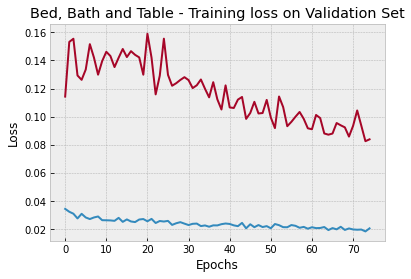

In [18]:
# Store the training in the history variable
history = mm.fit(df_train_x, df_train_y, validation_data=(df_valid_x, df_valid_y), epochs=75, verbose=0)
# See what is stored in the history
#history.history.keys()

#Plot training loss on validation set
loss = history.history["loss"]
vloss = history.history["val_loss"]

plt.plot(range(len(loss)), loss,)
plt.plot(range(len(loss)), vloss)


plt.title("Bed, Bath and Table - Training loss on Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [19]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_param('window_size', 55)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('num of units', 100)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('num of epochs', 75)
    mlflow.log_param('Google Trends Series','cama, mesa, banho, bed bath - topic')
    mlflow.log_param('Product Category','Bed, Bath and Table')
                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: ad48e348ee854fa3ace8e98b51d8c802


In [20]:
#metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True, param_prefix='validation')

### Plot Actuals & Forecasts

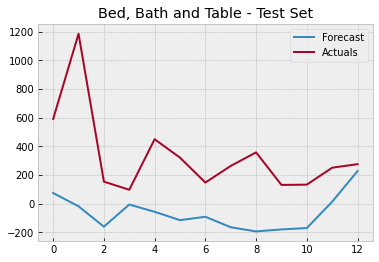

In [21]:
predictions = mm.predict(df_test_x); predictions
predictions = pv_scaler.inverse_transform(predictions);predictions
pv_scaler.inverse_transform(df_test_y).squeeze()

plt.plot(predictions, label='Forecast')
plt.plot(pv_scaler.inverse_transform(df_test_y).squeeze(),label='Actuals')
plt.legend()
plt.title('Bed, Bath and Table - Test Set')
plt.show()

### Plot Residuals

In [22]:
#Calcaulte Forecast Error
#error = predictions - pv_scaler.inverse_transform(df_test_y).squeeze()
#y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
#plt.scatter( x=y_true.index, y=y_true.residuals)
#plt.title('Bed, Bath and Table Residuals - Test Set ')
#plt.ylabel('Sales R$')
#plt.show()

#Histogram of Residuals
#plt.hist(x=error,density=True)
#plt.title('Histogram of Residuals - Test Set ')
#plt.show()

### Evaluate Performance

In [23]:
metrics.get_metrics(pv_scaler.inverse_transform(df_test_y).squeeze(),predictions, run_id=current_run_id,log=True,param_prefix='test')

wape: 140421.4611100192
rms: 485.30357552323926
r2: -1.9860137378221379
mape: 1.3436978870126834


# Product Category 2: Heath & Beauty <a name = "health_beauty"/>

In [24]:
#Filter on product categories (series)
health_beauty_train = df_train.loc[df_train['product_category_name'] == 'health_beauty'].copy()
health_beauty_valid = df_valid.loc[df_valid['product_category_name'] == 'health_beauty'].copy()
health_beauty_test = df_test.loc[df_test['product_category_name'] == 'health_beauty'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

health_beauty_train.drop(columns, inplace=True, axis=1)
health_beauty_valid.drop(columns, inplace=True, axis=1)
health_beauty_test.drop(columns, inplace=True, axis=1)

In [25]:
#Read and process GoogleTrends Series
base_dir_1 = "C:\\Users\\feras\\Documents\\Thesis_2020\\GoogleTrendsSeries\\"

cosmetics = pd.read_csv(os.path.join(base_dir_1,'cosmetics.csv')).iloc[1:]
contem1g = pd.read_csv(os.path.join(base_dir_1,'contem1g.csv')).iloc[1:]
natura = pd.read_csv(os.path.join(base_dir_1,'Natura_Cosmetics.csv')).iloc[1:]
suryabrasil = pd.read_csv(os.path.join(base_dir_1,'Surya_Brasil.csv')).iloc[1:]


cosmetics_gt =  utils.make_lag_features(cosmetics,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Make-Up & Cosmetics', 
                                   prefix_name='loja de cosmeticos_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})


contem1g_gt =  utils.make_lag_features(contem1g,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: All categories', 
                                   prefix_name='contem1g_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})

natura_gt =  utils.make_lag_features(natura,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Make-Up & Cosmetics', 
                                   prefix_name='natura_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})



surya_brasil_gt =  utils.make_lag_features(suryabrasil,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: All categories', 
                                   prefix_name='surya_brasil_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})



# we dont care about the prediction here. Drop category
cosmetics_gt.drop(columns='Category: Make-Up & Cosmetics', inplace=True)
cosmetics_gt = cosmetics_gt[cosmetics_gt.columns[::-1]]

contem1g_gt.drop(columns='Category: All categories', inplace=True)
contem1g_gt = contem1g_gt[contem1g_gt.columns[::-1]]

natura_gt.drop(columns='Category: Make-Up & Cosmetics', inplace=True)
natura_gt = natura_gt[natura_gt.columns[::-1]]

surya_brasil_gt.drop(columns='Category: All categories', inplace=True)
surya_brasil_gt = surya_brasil_gt[surya_brasil_gt.columns[::-1]]


In [26]:
cosmetics_gt['order_approved_at'] = pd.to_datetime(cosmetics_gt['order_approved_at'])

health_beauty_train = health_beauty_train[(health_beauty_train['order_approved_at'] >= cosmetics_gt['order_approved_at'].min()) &
                    (health_beauty_train['order_approved_at'] < cosmetics_gt['order_approved_at'].max())]

health_beauty_valid = health_beauty_valid[(health_beauty_valid['order_approved_at'] >= cosmetics_gt['order_approved_at'].min()) &
                    (health_beauty_valid['order_approved_at'] < cosmetics_gt['order_approved_at'].max())]

health_beauty_test = health_beauty_test[(health_beauty_test['order_approved_at'] >= cosmetics_gt['order_approved_at'].min()) &
                  (health_beauty_test['order_approved_at'] < cosmetics_gt['order_approved_at'].max())]

cosmetics_gt_train = cosmetics_gt[(cosmetics_gt['order_approved_at'] >= health_beauty_train['order_approved_at'].min()) &
                                           (cosmetics_gt['order_approved_at'] <= health_beauty_train['order_approved_at'].max())].copy()
cosmetics_gt_valid = cosmetics_gt[(cosmetics_gt['order_approved_at'] >= health_beauty_valid['order_approved_at'].min()) &
                                           (cosmetics_gt['order_approved_at'] <= health_beauty_valid['order_approved_at'].max())].copy()
cosmetics_gt_test = cosmetics_gt[(cosmetics_gt['order_approved_at'] >= health_beauty_test['order_approved_at'].min()) &
                                           (cosmetics_gt['order_approved_at'] <= health_beauty_test['order_approved_at'].max())].copy()


contem1g_gt['order_approved_at'] = pd.to_datetime(contem1g_gt['order_approved_at'])

health_beauty_train = health_beauty_train[(health_beauty_train['order_approved_at'] >= contem1g_gt['order_approved_at'].min()) &
                    (health_beauty_train['order_approved_at'] < contem1g_gt['order_approved_at'].max())]

health_beauty_valid = health_beauty_valid[(health_beauty_valid['order_approved_at'] >= contem1g_gt['order_approved_at'].min()) &
                    (health_beauty_valid['order_approved_at'] < contem1g_gt['order_approved_at'].max())]

health_beauty_test = health_beauty_test[(health_beauty_test['order_approved_at'] >= contem1g_gt['order_approved_at'].min()) &
                  (health_beauty_test['order_approved_at'] < contem1g_gt['order_approved_at'].max())]

contem1g_gt_train = contem1g_gt[(contem1g_gt['order_approved_at'] >= health_beauty_train['order_approved_at'].min()) &
                                           (contem1g_gt['order_approved_at'] <= health_beauty_train['order_approved_at'].max())].copy()
contem1g_gt_valid = contem1g_gt[(contem1g_gt['order_approved_at'] >= health_beauty_valid['order_approved_at'].min()) &
                                           (contem1g_gt['order_approved_at'] <= health_beauty_valid['order_approved_at'].max())].copy()
contem1g_gt_test = contem1g_gt[(contem1g_gt['order_approved_at'] >= health_beauty_test['order_approved_at'].min()) &
                                           (contem1g_gt['order_approved_at'] <= health_beauty_test['order_approved_at'].max())].copy()


natura_gt['order_approved_at'] = pd.to_datetime(natura_gt['order_approved_at'])

health_beauty_train = health_beauty_train[(health_beauty_train['order_approved_at'] >= natura_gt['order_approved_at'].min()) &
                    (health_beauty_train['order_approved_at'] < natura_gt['order_approved_at'].max())]

health_beauty_valid = health_beauty_valid[(health_beauty_valid['order_approved_at'] >= natura_gt['order_approved_at'].min()) &
                    (health_beauty_valid['order_approved_at'] < natura_gt['order_approved_at'].max())]

health_beauty_test = health_beauty_test[(health_beauty_test['order_approved_at'] >= natura_gt['order_approved_at'].min()) &
                  (health_beauty_test['order_approved_at'] < natura_gt['order_approved_at'].max())]

natura_gt_train = natura_gt[(natura_gt['order_approved_at'] >= health_beauty_train['order_approved_at'].min()) &
                                           (natura_gt['order_approved_at'] <= health_beauty_train['order_approved_at'].max())].copy()
natura_gt_valid = natura_gt[(natura_gt['order_approved_at'] >= health_beauty_valid['order_approved_at'].min()) &
                                           (natura_gt['order_approved_at'] <= health_beauty_valid['order_approved_at'].max())].copy()
natura_gt_test = natura_gt[(natura_gt['order_approved_at'] >= health_beauty_test['order_approved_at'].min()) &
                                           (natura_gt['order_approved_at'] <= health_beauty_test['order_approved_at'].max())].copy()


surya_brasil_gt['order_approved_at'] = pd.to_datetime(surya_brasil_gt['order_approved_at'])

health_beauty_train = health_beauty_train[(health_beauty_train['order_approved_at'] >= surya_brasil_gt['order_approved_at'].min()) &
                    (health_beauty_train['order_approved_at'] < surya_brasil_gt['order_approved_at'].max())]

health_beauty_valid = health_beauty_valid[(health_beauty_valid['order_approved_at'] >= surya_brasil_gt['order_approved_at'].min()) &
                    (health_beauty_valid['order_approved_at'] < surya_brasil_gt['order_approved_at'].max())]

health_beauty_test = health_beauty_test[(health_beauty_test['order_approved_at'] >= surya_brasil_gt['order_approved_at'].min()) &
                  (health_beauty_test['order_approved_at'] < surya_brasil_gt['order_approved_at'].max())]

surya_brasil_gt_train = surya_brasil_gt[(surya_brasil_gt['order_approved_at'] >= health_beauty_train['order_approved_at'].min()) &
                                           (surya_brasil_gt['order_approved_at'] <= health_beauty_train['order_approved_at'].max())].copy()
surya_brasil_gt_valid = surya_brasil_gt[(surya_brasil_gt['order_approved_at'] >= health_beauty_valid['order_approved_at'].min()) &
                                           (surya_brasil_gt['order_approved_at'] <= health_beauty_valid['order_approved_at'].max())].copy()
surya_brasil_gt_test = surya_brasil_gt[(surya_brasil_gt['order_approved_at'] >= health_beauty_test['order_approved_at'].min()) &
                                           (surya_brasil_gt['order_approved_at'] <= health_beauty_test['order_approved_at'].max())].copy()


In [27]:
# Drop unrequired columns
health_beauty_train = health_beauty_train.drop(columns=['order_approved_at'])
health_beauty_valid = health_beauty_valid.drop(columns=['order_approved_at'])
health_beauty_test = health_beauty_test.drop(columns=['order_approved_at'])

cosmetics_gt_train = cosmetics_gt_train.drop(columns=['order_approved_at'])
cosmetics_gt_valid = cosmetics_gt_valid.drop(columns=['order_approved_at'])
cosmetics_gt_test = cosmetics_gt_test.drop(columns=['order_approved_at'])

contem1g_gt_train = contem1g_gt_train.drop(columns=['order_approved_at'])
contem1g_gt_valid = contem1g_gt_valid.drop(columns=['order_approved_at'])
contem1g_gt_test = contem1g_gt_test.drop(columns=['order_approved_at'])

natura_gt_train = natura_gt_train.drop(columns=['order_approved_at'])
natura_gt_valid = natura_gt_valid.drop(columns=['order_approved_at'])
natura_gt_test = natura_gt_test.drop(columns=['order_approved_at'])

surya_brasil_gt_train = surya_brasil_gt_train.drop(columns=['order_approved_at'])
surya_brasil_gt_valid = surya_brasil_gt_valid.drop(columns=['order_approved_at'])
surya_brasil_gt_test = surya_brasil_gt_test.drop(columns=['order_approved_at'])

In [28]:
# Reshape and convert to numpy arrays
health_beauty_train = health_beauty_train.to_numpy().reshape(health_beauty_train.shape[0], health_beauty_train.shape[1], 1)
health_beauty_valid = health_beauty_valid.to_numpy().reshape(health_beauty_valid.shape[0], health_beauty_valid.shape[1], 1)
health_beauty_test = health_beauty_test.to_numpy().reshape(health_beauty_test.shape[0], health_beauty_test.shape[1], 1)

cosmetics_gt_train = cosmetics_gt_train.astype(int).to_numpy().reshape(cosmetics_gt_train.shape[0], 
                                                                               cosmetics_gt_train.shape[1], 1)
cosmetics_gt_valid = cosmetics_gt_valid.astype(int).to_numpy().reshape(cosmetics_gt_valid.shape[0], 
                                                                               cosmetics_gt_valid.shape[1], 1)
cosmetics_gt_test = cosmetics_gt_test.astype(int).to_numpy().reshape(cosmetics_gt_test.shape[0], 
                                                                             cosmetics_gt_test.shape[1], 1)

contem1g_gt_train = contem1g_gt_train.astype(int).to_numpy().reshape(contem1g_gt_train.shape[0], 
                                                                               contem1g_gt_train.shape[1], 1)
contem1g_gt_valid = contem1g_gt_valid.astype(int).to_numpy().reshape(contem1g_gt_valid.shape[0], 
                                                                               contem1g_gt_valid.shape[1], 1)
contem1g_gt_test = contem1g_gt_test.astype(int).to_numpy().reshape(contem1g_gt_test.shape[0], 
                                                                             contem1g_gt_test.shape[1], 1)

natura_gt_train = natura_gt_train.astype(int).to_numpy().reshape(natura_gt_train.shape[0], 
                                                                               natura_gt_train.shape[1], 1)
natura_gt_valid = natura_gt_valid.astype(int).to_numpy().reshape(natura_gt_valid.shape[0], 
                                                                               natura_gt_valid.shape[1], 1)
natura_gt_test = natura_gt_test.astype(int).to_numpy().reshape(natura_gt_test.shape[0], 
                                                                             natura_gt_test.shape[1], 1)

surya_brasil_gt_train = surya_brasil_gt_train.astype(int).to_numpy().reshape(surya_brasil_gt_train.shape[0], 
                                                                               surya_brasil_gt_train.shape[1], 1)
surya_brasil_gt_valid = surya_brasil_gt_valid.astype(int).to_numpy().reshape(surya_brasil_gt_valid.shape[0], 
                                                                               surya_brasil_gt_valid.shape[1], 1)
surya_brasil_gt_test = surya_brasil_gt_test.astype(int).to_numpy().reshape(surya_brasil_gt_test.shape[0], 
                                                                             surya_brasil_gt_test.shape[1], 1)

In [29]:
health_beauty_train.shape

(88, 56, 1)

In [30]:
# Scaling datasets
pv_scaler = MinMaxScalerDf()
health_beauty_train = pv_scaler.fit_transform(health_beauty_train)
health_beauty_valid = pv_scaler.transform(health_beauty_valid)
health_beauty_test = pv_scaler.transform(health_beauty_test)

gt_scaler = MinMaxScalerDf()
cosmetics_gt_train = gt_scaler.fit_transform(cosmetics_gt_train)
cosmetics_gt_valid = gt_scaler.transform(cosmetics_gt_valid)
cosmetics_gt_test = gt_scaler.transform(cosmetics_gt_test)

contem1g_gt_train = gt_scaler.fit_transform(contem1g_gt_train)
contem1g_gt_valid = gt_scaler.transform(contem1g_gt_valid)
contem1g_gt_test = gt_scaler.transform(contem1g_gt_test)


natura_gt_train = gt_scaler.fit_transform(natura_gt_train)
natura_gt_valid = gt_scaler.transform(natura_gt_valid)
natura_gt_test = gt_scaler.transform(natura_gt_test)

surya_brasil_gt_train = gt_scaler.fit_transform(surya_brasil_gt_train)
surya_brasil_gt_valid = gt_scaler.transform(surya_brasil_gt_valid)
surya_brasil_gt_test = gt_scaler.transform(surya_brasil_gt_test)


df_train_x = health_beauty_train[:,:-1,:]
df_train_y = health_beauty_train[:,-1:,:]
df_valid_x = health_beauty_valid[:,:-1,:]
df_valid_y = health_beauty_valid[:,-1:,:]
df_test_x = health_beauty_test[:,:-1,:]
df_test_y = health_beauty_test[:,-1:,:]

In [31]:
# Time to concatenate the data together
# This should be commented out if you want to try without google trends, and specify num_series = 1 in the bellow function (a_model)

df_train_x = np.concatenate([df_train_x,cosmetics_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,cosmetics_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,cosmetics_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,contem1g_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,contem1g_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,contem1g_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,natura_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,natura_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,natura_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,surya_brasil_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,surya_brasil_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,surya_brasil_gt_test], axis=2)

In [32]:
df_train_x.shape

(88, 55, 5)

### Define Long Short Term Memory Model

In [33]:
def a_model():
    num_timesteps = 55 # the number of lags in the dataframes
    num_series = 5     # the number of time series, specify 1 if univariate!
    num_units = 100    # the number of hidden units
    
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(num_timesteps, num_series)))
    model.add(Dropout(0.1)) # Prevent overfitting
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [34]:
# Initialize model, specify the training data, to get the input shape
mm = a_model()

In [35]:
mm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


### Train Model, Report & Visualize Performance on the Validation Set

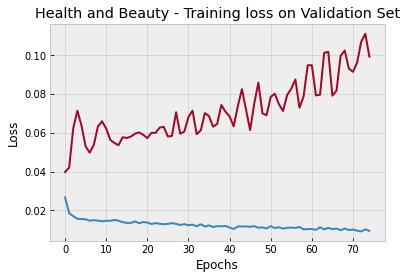

In [36]:
# Store the training in the history variable
history = mm.fit(df_train_x, df_train_y, validation_data=(df_valid_x, df_valid_y), epochs=75, verbose=0)
# See what is stored in the history
#history.history.keys()

#Plot training loss on validation set
loss = history.history["loss"]
vloss = history.history["val_loss"]

plt.plot(range(len(loss)), loss,)
plt.plot(range(len(loss)), vloss)


plt.title("Health and Beauty - Training loss on Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [37]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_param('window_size', 55)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('num of units', 100)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('num of epochs', 75)
    mlflow.log_param('Google Trends Series','loja de cosmetics, contem 1g, natura cosmetics, surya brasil')
    mlflow.log_param('Product Category','Health and Beauty')
                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: e4a04d195c554172b3341e89f41ddd6d


In [38]:
#metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

### Plot Actuals & Forecasts

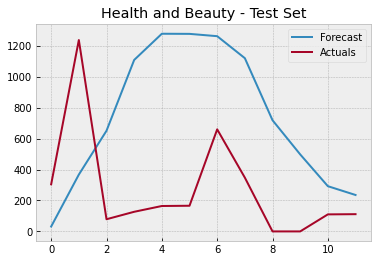

In [39]:
predictions = mm.predict(df_test_x); predictions
predictions = pv_scaler.inverse_transform(predictions);predictions
pv_scaler.inverse_transform(df_test_y).squeeze()

plt.plot(predictions, label='Forecast')
plt.plot(pv_scaler.inverse_transform(df_test_y).squeeze(),label='Actuals')
plt.legend()
plt.title('Health and Beauty - Test Set')
plt.show()

### Plot Residuals

In [40]:
#Calcaulte Forecast Error
#error = predictions - pv_scaler.inverse_transform(df_test_y).squeeze()
#y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
#plt.scatter( x=y_true.index, y=y_true.residuals)
#plt.title('Bed, Bath and Table Residuals - Test Set ')
#plt.ylabel('Sales R$')
#plt.show()

#Histogram of Residuals
#plt.hist(x=error,density=True)
#plt.title('Histogram of Residuals - Test Set ')
#plt.show()

### Evaluate Performance

In [41]:
metrics.get_metrics(pv_scaler.inverse_transform(df_test_y).squeeze(),predictions, run_id=current_run_id,log=True,param_prefix='test')

wape: 121224.94596034993
rms: 728.5807010683609
r2: -3.6491458793222593
mape: 125.76742716892795


# Product Category 3: Sports and Leisure <a name = "sports_leisure"/>

In [42]:
#Filter on product categories (series)
sports_leisure_train = df_train.loc[df_train['product_category_name'] == 'sports_leisure'].copy()
sports_leisure_valid = df_valid.loc[df_valid['product_category_name'] == 'sports_leisure'].copy()
sports_leisure_test = df_test.loc[df_test['product_category_name'] == 'sports_leisure'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

sports_leisure_train.drop(columns, inplace=True, axis=1)
sports_leisure_valid.drop(columns, inplace=True, axis=1)
sports_leisure_test.drop(columns, inplace=True, axis=1)

In [43]:
nike = pd.read_csv(os.path.join(base_dir_1,'Nike_Masculino.csv')).iloc[1:]
adidas = pd.read_csv(os.path.join(base_dir_1,'Adidas_Yeezy.csv')).iloc[1:]
arezzo = pd.read_csv(os.path.join(base_dir_1,'Arezzo.csv')).iloc[1:]


nike_gt =  utils.make_lag_features(nike,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: All categories', 
                                   prefix_name='nike_masculino_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})


adidas_gt =  utils.make_lag_features(adidas,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: All categories', 
                                   prefix_name='adidas_yeezy_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})




arezzo_gt =  utils.make_lag_features(arezzo,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: All categories', 
                                   prefix_name='arezzo_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})




# we dont care about the prediction here. Drop category
nike_gt.drop(columns='Category: All categories', inplace=True)
nike_gt = nike_gt[nike_gt.columns[::-1]]

adidas_gt.drop(columns='Category: All categories', inplace=True)
adidas_gt = adidas_gt[adidas_gt.columns[::-1]]


arezzo_gt.drop(columns='Category: All categories', inplace=True)
arezzo_gt = arezzo_gt[arezzo_gt.columns[::-1]]


In [44]:
nike_gt['order_approved_at'] = pd.to_datetime(nike_gt['order_approved_at'])

sports_leisure_train = sports_leisure_train[(sports_leisure_train['order_approved_at'] >= nike_gt['order_approved_at'].min()) &
                    (sports_leisure_train['order_approved_at'] < nike_gt['order_approved_at'].max())]

sports_leisure_valid = sports_leisure_valid[(sports_leisure_valid['order_approved_at'] >= nike_gt['order_approved_at'].min()) &
                    (sports_leisure_valid['order_approved_at'] < nike_gt['order_approved_at'].max())]

sports_leisure_test = sports_leisure_test[(sports_leisure_test['order_approved_at'] >= nike_gt['order_approved_at'].min()) &
                  (sports_leisure_test['order_approved_at'] < nike_gt['order_approved_at'].max())]

nike_gt_train = nike_gt[(nike_gt['order_approved_at'] >= sports_leisure_train['order_approved_at'].min()) &
                                           (nike_gt['order_approved_at'] <= sports_leisure_train['order_approved_at'].max())].copy()
nike_gt_valid = nike_gt[(nike_gt['order_approved_at'] >= sports_leisure_valid['order_approved_at'].min()) &
                                           (nike_gt['order_approved_at'] <= sports_leisure_valid['order_approved_at'].max())].copy()
nike_gt_test = nike_gt[(nike_gt['order_approved_at'] >= sports_leisure_test['order_approved_at'].min()) &
                                           (nike_gt['order_approved_at'] <= sports_leisure_test['order_approved_at'].max())].copy()

adidas_gt['order_approved_at'] = pd.to_datetime(adidas_gt['order_approved_at'])

sports_leisure_train = sports_leisure_train[(sports_leisure_train['order_approved_at'] >= adidas_gt['order_approved_at'].min()) &
                    (sports_leisure_train['order_approved_at'] < adidas_gt['order_approved_at'].max())]

sports_leisure_valid = sports_leisure_valid[(sports_leisure_valid['order_approved_at'] >= adidas_gt['order_approved_at'].min()) &
                    (sports_leisure_valid['order_approved_at'] < adidas_gt['order_approved_at'].max())]

sports_leisure_test = sports_leisure_test[(sports_leisure_test['order_approved_at'] >= adidas_gt['order_approved_at'].min()) &
                  (sports_leisure_test['order_approved_at'] < adidas_gt['order_approved_at'].max())]

adidas_gt_train = adidas_gt[(adidas_gt['order_approved_at'] >= sports_leisure_train['order_approved_at'].min()) &
                                           (adidas_gt['order_approved_at'] <= sports_leisure_train['order_approved_at'].max())].copy()
adidas_gt_valid = adidas_gt[(adidas_gt['order_approved_at'] >= sports_leisure_valid['order_approved_at'].min()) &
                                           (adidas_gt['order_approved_at'] <= sports_leisure_valid['order_approved_at'].max())].copy()
adidas_gt_test = adidas_gt[(adidas_gt['order_approved_at'] >= sports_leisure_test['order_approved_at'].min()) &
                                           (adidas_gt['order_approved_at'] <= sports_leisure_test['order_approved_at'].max())].copy()

arezzo_gt['order_approved_at'] = pd.to_datetime(arezzo_gt['order_approved_at'])

sports_leisure_train = sports_leisure_train[(sports_leisure_train['order_approved_at'] >= arezzo_gt['order_approved_at'].min()) &
                    (sports_leisure_train['order_approved_at'] < arezzo_gt['order_approved_at'].max())]

sports_leisure_valid = sports_leisure_valid[(sports_leisure_valid['order_approved_at'] >= arezzo_gt['order_approved_at'].min()) &
                    (sports_leisure_valid['order_approved_at'] < arezzo_gt['order_approved_at'].max())]

sports_leisure_test = sports_leisure_test[(sports_leisure_test['order_approved_at'] >= arezzo_gt['order_approved_at'].min()) &
                  (sports_leisure_test['order_approved_at'] < arezzo_gt['order_approved_at'].max())]

arezzo_gt_train = arezzo_gt[(arezzo_gt['order_approved_at'] >= sports_leisure_train['order_approved_at'].min()) &
                                           (arezzo_gt['order_approved_at'] <= sports_leisure_train['order_approved_at'].max())].copy()
arezzo_gt_valid = arezzo_gt[(arezzo_gt['order_approved_at'] >= sports_leisure_valid['order_approved_at'].min()) &
                                           (arezzo_gt['order_approved_at'] <= sports_leisure_valid['order_approved_at'].max())].copy()
arezzo_gt_test = arezzo_gt[(arezzo_gt['order_approved_at'] >= sports_leisure_test['order_approved_at'].min()) &
                                           (arezzo_gt['order_approved_at'] <= sports_leisure_test['order_approved_at'].max())].copy()


In [45]:
# Drop unrequired columns
sports_leisure_train = sports_leisure_train.drop(columns=['order_approved_at'])
sports_leisure_valid = sports_leisure_valid.drop(columns=['order_approved_at'])
sports_leisure_test = sports_leisure_test.drop(columns=['order_approved_at'])

nike_gt_train = nike_gt_train.drop(columns=['order_approved_at'])
nike_gt_valid = nike_gt_valid.drop(columns=['order_approved_at'])
nike_gt_test = nike_gt_test.drop(columns=['order_approved_at'])

adidas_gt_train = adidas_gt_train.drop(columns=['order_approved_at'])
adidas_gt_valid = adidas_gt_valid.drop(columns=['order_approved_at'])
adidas_gt_test = adidas_gt_test.drop(columns=['order_approved_at'])

arezzo_gt_train = arezzo_gt_train.drop(columns=['order_approved_at'])
arezzo_gt_valid = arezzo_gt_valid.drop(columns=['order_approved_at'])
arezzo_gt_test = arezzo_gt_test.drop(columns=['order_approved_at'])


In [46]:
# Reshape and convert to numpy arrays
sports_leisure_train = sports_leisure_train.to_numpy().reshape(sports_leisure_train.shape[0], sports_leisure_train.shape[1], 1)
sports_leisure_valid = sports_leisure_valid.to_numpy().reshape(sports_leisure_valid.shape[0], sports_leisure_valid.shape[1], 1)
sports_leisure_test = sports_leisure_test.to_numpy().reshape(sports_leisure_test.shape[0], sports_leisure_test.shape[1], 1)


nike_gt_train = nike_gt_train.astype(int).to_numpy().reshape(nike_gt_train.shape[0], 
                                                                               nike_gt_train.shape[1], 1)
nike_gt_valid = nike_gt_valid.astype(int).to_numpy().reshape(nike_gt_valid.shape[0], 
                                                                               nike_gt_valid.shape[1], 1)
nike_gt_test = nike_gt_test.astype(int).to_numpy().reshape(nike_gt_test.shape[0], 
                                                                             nike_gt_test.shape[1], 1)

adidas_gt_train = adidas_gt_train.astype(int).to_numpy().reshape(adidas_gt_train.shape[0], 
                                                                               adidas_gt_train.shape[1], 1)
adidas_gt_valid = adidas_gt_valid.astype(int).to_numpy().reshape(adidas_gt_valid.shape[0], 
                                                                               adidas_gt_valid.shape[1], 1)
adidas_gt_test = adidas_gt_test.astype(int).to_numpy().reshape(adidas_gt_test.shape[0], 
                                                                             adidas_gt_test.shape[1], 1)

arezzo_gt_train = arezzo_gt_train.astype(int).to_numpy().reshape(arezzo_gt_train.shape[0], 
                                                                               arezzo_gt_train.shape[1], 1)
arezzo_gt_valid = arezzo_gt_valid.astype(int).to_numpy().reshape(arezzo_gt_valid.shape[0], 
                                                                               arezzo_gt_valid.shape[1], 1)
arezzo_gt_test = arezzo_gt_test.astype(int).to_numpy().reshape(arezzo_gt_test.shape[0], 
                                                                             arezzo_gt_test.shape[1], 1)



In [47]:
sports_leisure_train.shape

(88, 56, 1)

In [48]:
# Scaling datasets
pv_scaler = MinMaxScalerDf()
sports_leisure_train = pv_scaler.fit_transform(sports_leisure_train)
sports_leisure_valid = pv_scaler.transform(sports_leisure_valid)
sports_leisure_test = pv_scaler.transform(sports_leisure_test)

gt_scaler = MinMaxScalerDf()
nike_gt_train = gt_scaler.fit_transform(nike_gt_train)
nike_gt_valid = gt_scaler.transform(nike_gt_valid)
nike_gt_test = gt_scaler.transform(nike_gt_test)

adidas_gt_train = gt_scaler.fit_transform(adidas_gt_train)
adidas_gt_valid = gt_scaler.transform(adidas_gt_valid)
adidas_gt_test = gt_scaler.transform(adidas_gt_test)

arezzo_gt_train = gt_scaler.fit_transform(arezzo_gt_train)
arezzo_gt_valid = gt_scaler.transform(arezzo_gt_valid)
arezzo_gt_test = gt_scaler.transform(arezzo_gt_test)

df_train_x = sports_leisure_train[:,:-1,:]
df_train_y = sports_leisure_train[:,-1:,:]
df_valid_x = sports_leisure_valid[:,:-1,:]
df_valid_y = sports_leisure_valid[:,-1:,:]
df_test_x = sports_leisure_test[:,:-1,:]
df_test_y = sports_leisure_test[:,-1:,:]

In [49]:
# Time to concatenate the data together
# This should be commented out if you want to try without google trends, and specify num_series = 1 in the bellow function (a_model)
df_train_x = np.concatenate([df_train_x,nike_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,nike_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,nike_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,adidas_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,adidas_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,adidas_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,arezzo_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,arezzo_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,arezzo_gt_test], axis=2)

In [50]:
df_train_x.shape

(88, 55, 4)

### Define Long Short Term Memory Model

In [51]:
def a_model():
    num_timesteps = 55 # the number of lags in the dataframes
    num_series = 4     # the number of time series, specify 1 if univariate!
    num_units = 100    # the number of hidden units
    
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(num_timesteps, num_series)))
    model.add(Dropout(0.1)) # Prevent overfitting
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [52]:
# Initialize model, specify the training data, to get the input shape
mm = a_model()

In [53]:
mm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               42000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 42,101
Trainable params: 42,101
Non-trainable params: 0
_________________________________________________________________


### Train Model, Report & Visualize Performance on the Validation Set

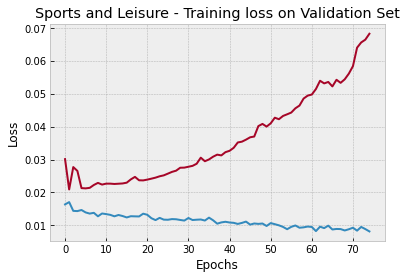

In [54]:
# Store the training in the history variable
history = mm.fit(df_train_x, df_train_y, validation_data=(df_valid_x, df_valid_y), epochs=75, verbose=0)
# See what is stored in the history
#history.history.keys()

#Plot training loss on validation set
loss = history.history["loss"]
vloss = history.history["val_loss"]

plt.plot(range(len(loss)), loss,)
plt.plot(range(len(loss)), vloss)


plt.title("Sports and Leisure - Training loss on Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [55]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_param('window_size', 55)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('num of units', 100)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('num of epochs', 75)
    mlflow.log_param('Google Trends Series','nike masculino, Adidas Yeezy, Arezzo')
    mlflow.log_param('Product Category','Sports and Leisure')
                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: fa6b00951137455f9ed2e6032012c372


In [56]:
#metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

### Plot Actuals & Forecasts

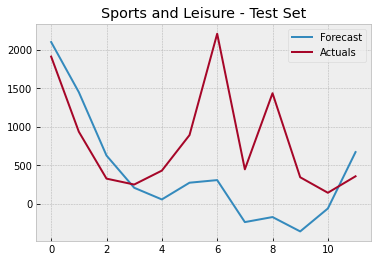

In [57]:
predictions = mm.predict(df_test_x); predictions
predictions = pv_scaler.inverse_transform(predictions);predictions
pv_scaler.inverse_transform(df_test_y).squeeze()

plt.plot(predictions, label='Forecast')
plt.plot(pv_scaler.inverse_transform(df_test_y).squeeze(),label='Actuals')
plt.legend()
plt.title('Sports and Leisure - Test Set')
plt.show()

### Plot Residuals

In [58]:
#Calcaulte Forecast Error
#error = predictions - pv_scaler.inverse_transform(df_test_y).squeeze()
#y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
#plt.scatter( x=y_true.index, y=y_true.residuals)
#plt.title('Bed, Bath and Table Residuals - Test Set ')
#plt.ylabel('Sales R$')
#plt.show()

#Histogram of Residuals
#plt.hist(x=error,density=True)
#plt.title('Histogram of Residuals - Test Set ')
#plt.show()

### Evaluate Performance

In [59]:
metrics.get_metrics(pv_scaler.inverse_transform(df_test_y).squeeze(),predictions, run_id=current_run_id,log=True,param_prefix='test')

wape: 550932.6931634761
rms: 827.1830494130522
r2: -0.5590774941953844
mape: 1.3853487918004153


# Product Category 4: Furniture Decor <a name = "furniture_decor"/>

In [60]:
#Filter on product categories (series)
furniture_decor_train = df_train.loc[df_train['product_category_name'] == 'furniture_decor'].copy()
furniture_decor_valid = df_valid.loc[df_valid['product_category_name'] == 'furniture_decor'].copy()
furniture_decor_test = df_test.loc[df_test['product_category_name'] == 'furniture_decor'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

furniture_decor_train.drop(columns, inplace=True, axis=1)
furniture_decor_valid.drop(columns, inplace=True, axis=1)
furniture_decor_test.drop(columns, inplace=True, axis=1)

In [61]:
couch = pd.read_csv(os.path.join(base_dir_1,'Couch.csv')).iloc[1:]
furniture = pd.read_csv(os.path.join(base_dir_1,'Furniture.csv')).iloc[1:]
etna = pd.read_csv(os.path.join(base_dir_1,'Etna.csv')).iloc[1:]
xmasdecor = pd.read_csv(os.path.join(base_dir_1,'xmas_decoration.csv')).iloc[1:]

couch_gt =  utils.make_lag_features(couch,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Home Furnishings', 
                                   prefix_name='couch_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})

furniture_gt =  utils.make_lag_features(furniture,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Home Furnishings', 
                                   prefix_name='móveis_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})

    
etna_gt =  utils.make_lag_features(etna,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: All categories', 
                                   prefix_name='etna móveis_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})


xmasdecor_gt =  utils.make_lag_features(xmasdecor,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: All categories', 
                                   prefix_name='Christmas decoration_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})


# we dont care about the prediction here. Drop category
couch_gt.drop(columns='Category: Home Furnishings', inplace=True)
couch_gt = couch_gt[couch_gt.columns[::-1]]

furniture_gt.drop(columns='Category: Home Furnishings', inplace=True)
furniture_gt = furniture_gt[furniture_gt.columns[::-1]]

etna_gt.drop(columns='Category: All categories', inplace=True)
etna_gt = etna_gt[etna_gt.columns[::-1]]


xmasdecor_gt.drop(columns='Category: All categories', inplace=True)
xmasdecor_gt = xmasdecor_gt[xmasdecor_gt.columns[::-1]]

In [62]:
couch_gt['order_approved_at'] = pd.to_datetime(couch_gt['order_approved_at'])

furniture_decor_train = furniture_decor_train[(furniture_decor_train['order_approved_at'] >= couch_gt['order_approved_at'].min()) &
                    (furniture_decor_train['order_approved_at'] < couch_gt['order_approved_at'].max())]

furniture_decor_valid = furniture_decor_valid[(furniture_decor_valid['order_approved_at'] >= couch_gt['order_approved_at'].min()) &
                    (furniture_decor_valid['order_approved_at'] < couch_gt['order_approved_at'].max())]

furniture_decor_test = furniture_decor_test[(furniture_decor_test['order_approved_at'] >= couch_gt['order_approved_at'].min()) &
                  (furniture_decor_test['order_approved_at'] < couch_gt['order_approved_at'].max())]

couch_gt_train = couch_gt[(couch_gt['order_approved_at'] >= furniture_decor_train['order_approved_at'].min()) &
                                           (couch_gt['order_approved_at'] <= furniture_decor_train['order_approved_at'].max())].copy()
couch_gt_valid = couch_gt[(couch_gt['order_approved_at'] >= furniture_decor_valid['order_approved_at'].min()) &
                                           (couch_gt['order_approved_at'] <= furniture_decor_valid['order_approved_at'].max())].copy()
couch_gt_test = couch_gt[(couch_gt['order_approved_at'] >= furniture_decor_test['order_approved_at'].min()) &
                                           (couch_gt['order_approved_at'] <= furniture_decor_test['order_approved_at'].max())].copy()


furniture_gt['order_approved_at'] = pd.to_datetime(furniture_gt['order_approved_at'])

furniture_decor_train = furniture_decor_train[(furniture_decor_train['order_approved_at'] >= furniture_gt['order_approved_at'].min()) &
                    (furniture_decor_train['order_approved_at'] < furniture_gt['order_approved_at'].max())]

furniture_decor_valid = furniture_decor_valid[(furniture_decor_valid['order_approved_at'] >= furniture_gt['order_approved_at'].min()) &
                    (furniture_decor_valid['order_approved_at'] < furniture_gt['order_approved_at'].max())]

furniture_decor_test = furniture_decor_test[(furniture_decor_test['order_approved_at'] >= furniture_gt['order_approved_at'].min()) &
                  (furniture_decor_test['order_approved_at'] < furniture_gt['order_approved_at'].max())]

furniture_gt_train = furniture_gt[(furniture_gt['order_approved_at'] >= furniture_decor_train['order_approved_at'].min()) &
                                           (furniture_gt['order_approved_at'] <= furniture_decor_train['order_approved_at'].max())].copy()
furniture_gt_valid = furniture_gt[(furniture_gt['order_approved_at'] >= furniture_decor_valid['order_approved_at'].min()) &
                                           (furniture_gt['order_approved_at'] <= furniture_decor_valid['order_approved_at'].max())].copy()
furniture_gt_test = furniture_gt[(furniture_gt['order_approved_at'] >= furniture_decor_test['order_approved_at'].min()) &
                                           (furniture_gt['order_approved_at'] <= furniture_decor_test['order_approved_at'].max())].copy()


etna_gt['order_approved_at'] = pd.to_datetime(etna_gt['order_approved_at'])

furniture_decor_train = furniture_decor_train[(furniture_decor_train['order_approved_at'] >= etna_gt['order_approved_at'].min()) &
                    (furniture_decor_train['order_approved_at'] < etna_gt['order_approved_at'].max())]

furniture_decor_valid = furniture_decor_valid[(furniture_decor_valid['order_approved_at'] >= etna_gt['order_approved_at'].min()) &
                    (furniture_decor_valid['order_approved_at'] < etna_gt['order_approved_at'].max())]

furniture_decor_test = furniture_decor_test[(furniture_decor_test['order_approved_at'] >= etna_gt['order_approved_at'].min()) &
                  (furniture_decor_test['order_approved_at'] < etna_gt['order_approved_at'].max())]

etna_gt_train = etna_gt[(etna_gt['order_approved_at'] >= furniture_decor_train['order_approved_at'].min()) &
                                           (etna_gt['order_approved_at'] <= furniture_decor_train['order_approved_at'].max())].copy()
etna_gt_valid = etna_gt[(etna_gt['order_approved_at'] >= furniture_decor_valid['order_approved_at'].min()) &
                                           (etna_gt['order_approved_at'] <= furniture_decor_valid['order_approved_at'].max())].copy()
etna_gt_test = etna_gt[(etna_gt['order_approved_at'] >= furniture_decor_test['order_approved_at'].min()) &
                                           (etna_gt['order_approved_at'] <= furniture_decor_test['order_approved_at'].max())].copy()


xmasdecor_gt['order_approved_at'] = pd.to_datetime(xmasdecor_gt['order_approved_at'])

furniture_decor_train = furniture_decor_train[(furniture_decor_train['order_approved_at'] >= xmasdecor_gt['order_approved_at'].min()) &
                    (furniture_decor_train['order_approved_at'] < xmasdecor_gt['order_approved_at'].max())]

furniture_decor_valid = furniture_decor_valid[(furniture_decor_valid['order_approved_at'] >= xmasdecor_gt['order_approved_at'].min()) &
                    (furniture_decor_valid['order_approved_at'] < xmasdecor_gt['order_approved_at'].max())]

furniture_decor_test = furniture_decor_test[(furniture_decor_test['order_approved_at'] >= xmasdecor_gt['order_approved_at'].min()) &
                  (furniture_decor_test['order_approved_at'] < xmasdecor_gt['order_approved_at'].max())]

xmasdecor_gt_train = xmasdecor_gt[(xmasdecor_gt['order_approved_at'] >= furniture_decor_train['order_approved_at'].min()) &
                                           (xmasdecor_gt['order_approved_at'] <= furniture_decor_train['order_approved_at'].max())].copy()
xmasdecor_gt_valid = xmasdecor_gt[(xmasdecor_gt['order_approved_at'] >= furniture_decor_valid['order_approved_at'].min()) &
                                           (xmasdecor_gt['order_approved_at'] <= furniture_decor_valid['order_approved_at'].max())].copy()
xmasdecor_gt_test = xmasdecor_gt[(xmasdecor_gt['order_approved_at'] >= furniture_decor_test['order_approved_at'].min()) &
                                           (xmasdecor_gt['order_approved_at'] <= furniture_decor_test['order_approved_at'].max())].copy()

In [63]:
# Drop unrequired columns
furniture_decor_train = furniture_decor_train.drop(columns=['order_approved_at'])
furniture_decor_valid = furniture_decor_valid.drop(columns=['order_approved_at'])
furniture_decor_test = furniture_decor_test.drop(columns=['order_approved_at'])

couch_gt_train = couch_gt_train.drop(columns=['order_approved_at'])
couch_gt_valid = couch_gt_valid.drop(columns=['order_approved_at'])
couch_gt_test = couch_gt_test.drop(columns=['order_approved_at'])

furniture_gt_train = furniture_gt_train.drop(columns=['order_approved_at'])
furniture_gt_valid = furniture_gt_valid.drop(columns=['order_approved_at'])
furniture_gt_test = furniture_gt_test.drop(columns=['order_approved_at'])

etna_gt_train = etna_gt_train.drop(columns=['order_approved_at'])
etna_gt_valid = etna_gt_valid.drop(columns=['order_approved_at'])
etna_gt_test = etna_gt_test.drop(columns=['order_approved_at'])

xmasdecor_gt_train = xmasdecor_gt_train.drop(columns=['order_approved_at'])
xmasdecor_gt_valid = xmasdecor_gt_valid.drop(columns=['order_approved_at'])
xmasdecor_gt_test = xmasdecor_gt_test.drop(columns=['order_approved_at'])


In [64]:
# Reshape and convert to numpy arrays
furniture_decor_train = furniture_decor_train.to_numpy().reshape(furniture_decor_train.shape[0], furniture_decor_train.shape[1], 1)
furniture_decor_valid = furniture_decor_valid.to_numpy().reshape(furniture_decor_valid.shape[0], furniture_decor_valid.shape[1], 1)
furniture_decor_test = furniture_decor_test.to_numpy().reshape(furniture_decor_test.shape[0], furniture_decor_test.shape[1], 1)


couch_gt_train = couch_gt_train.astype(int).to_numpy().reshape(couch_gt_train.shape[0], 
                                                                               couch_gt_train.shape[1], 1)
couch_gt_valid = couch_gt_valid.astype(int).to_numpy().reshape(couch_gt_valid.shape[0], 
                                                                               couch_gt_valid.shape[1], 1)
couch_gt_test = couch_gt_test.astype(int).to_numpy().reshape(couch_gt_test.shape[0], 
                                                                             couch_gt_test.shape[1], 1)


furniture_gt_train = furniture_gt_train.astype(int).to_numpy().reshape(furniture_gt_train.shape[0], 
                                                                               furniture_gt_train.shape[1], 1)
furniture_gt_valid = furniture_gt_valid.astype(int).to_numpy().reshape(furniture_gt_valid.shape[0], 
                                                                               furniture_gt_valid.shape[1], 1)
furniture_gt_test = furniture_gt_test.astype(int).to_numpy().reshape(furniture_gt_test.shape[0], 
                                                                             furniture_gt_test.shape[1], 1)


etna_gt_train = etna_gt_train.astype(int).to_numpy().reshape(etna_gt_train.shape[0], 
                                                                               etna_gt_train.shape[1], 1)
etna_gt_valid = etna_gt_valid.astype(int).to_numpy().reshape(etna_gt_valid.shape[0], 
                                                                               etna_gt_valid.shape[1], 1)
etna_gt_test = etna_gt_test.astype(int).to_numpy().reshape(etna_gt_test.shape[0], 
                                                                             etna_gt_test.shape[1], 1)


xmasdecor_gt_train = xmasdecor_gt_train.astype(int).to_numpy().reshape(xmasdecor_gt_train.shape[0], 
                                                                               xmasdecor_gt_train.shape[1], 1)
xmasdecor_gt_valid = xmasdecor_gt_valid.astype(int).to_numpy().reshape(xmasdecor_gt_valid.shape[0], 
                                                                               xmasdecor_gt_valid.shape[1], 1)
xmasdecor_gt_test = xmasdecor_gt_test.astype(int).to_numpy().reshape(xmasdecor_gt_test.shape[0], 
                                                                             xmasdecor_gt_test.shape[1], 1)

In [65]:
furniture_decor_train.shape

(88, 56, 1)

In [66]:
# Scaling datasets
pv_scaler = MinMaxScalerDf()
furniture_decor_train = pv_scaler.fit_transform(furniture_decor_train)
furniture_decor_valid = pv_scaler.transform(furniture_decor_valid)
furniture_decor_test = pv_scaler.transform(furniture_decor_test)

gt_scaler = MinMaxScalerDf()
couch_gt_train = gt_scaler.fit_transform(couch_gt_train)
couch_gt_valid = gt_scaler.transform(couch_gt_valid)
couch_gt_test = gt_scaler.transform(couch_gt_test)

furniture_gt_train = gt_scaler.fit_transform(furniture_gt_train)
furniture_gt_valid = gt_scaler.transform(furniture_gt_valid)
furniture_gt_test = gt_scaler.transform(furniture_gt_test)

etna_gt_train = gt_scaler.fit_transform(etna_gt_train)
etna_gt_valid = gt_scaler.transform(etna_gt_valid)
etna_gt_test = gt_scaler.transform(etna_gt_test)

xmasdecor_gt_train = gt_scaler.fit_transform(xmasdecor_gt_train)
xmasdecor_gt_valid = gt_scaler.transform(xmasdecor_gt_valid)
xmasdecor_gt_test = gt_scaler.transform(xmasdecor_gt_test)

df_train_x = furniture_decor_train[:,:-1,:]
df_train_y = furniture_decor_train[:,-1:,:]
df_valid_x = furniture_decor_valid[:,:-1,:]
df_valid_y = furniture_decor_valid[:,-1:,:]
df_test_x = furniture_decor_test[:,:-1,:]
df_test_y = furniture_decor_test[:,-1:,:]

In [67]:
# Time to concatenate the data together
# This should be commented out if you want to try without google trends, and specify num_series = 1 in the bellow function (a_model)
df_train_x = np.concatenate([df_train_x,couch_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,couch_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,couch_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,furniture_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,furniture_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,furniture_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,etna_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,etna_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,etna_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,xmasdecor_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,xmasdecor_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,xmasdecor_gt_test], axis=2)

In [68]:
df_train_x.shape

(88, 55, 5)

### Define Long Short Term Memory Model

In [69]:
def a_model():
    num_timesteps = 55 # the number of lags in the dataframes
    num_series = 5     # the number of time series, specify 1 if univariate!
    num_units = 100    # the number of hidden units
    
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(num_timesteps, num_series)))
    model.add(Dropout(0.1)) # Prevent overfitting
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [70]:
# Initialize model, specify the training data, to get the input shape
mm = a_model()

In [71]:
mm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


### Train Model, Report & Visualize Performance on the Validation Set

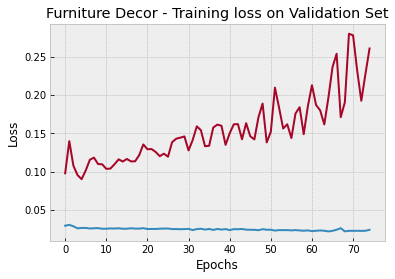

In [72]:
# Store the training in the history variable
history = mm.fit(df_train_x, df_train_y, validation_data=(df_valid_x, df_valid_y), epochs=75, verbose=0)
# See what is stored in the history
#history.history.keys()

#Plot training loss on validation set
loss = history.history["loss"]
vloss = history.history["val_loss"]

plt.plot(range(len(loss)), loss,)
plt.plot(range(len(loss)), vloss)


plt.title("Furniture Decor - Training loss on Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [73]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_param('window_size', 55)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('num of units', 100)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('num of epochs', 75)
    mlflow.log_param('Google Trends Series','couch, Móveis, Etna Móveis, Christmas decoration')
    mlflow.log_param('Product Category','Furniture Decor')
                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: bf40c248816940a1860bd888fb4fd185


In [74]:
#metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True, param_prefix='validation')

### Plot Actuals & Forecasts

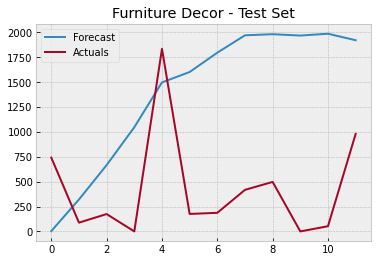

In [75]:
predictions = mm.predict(df_test_x); predictions
predictions = pv_scaler.inverse_transform(predictions);predictions
pv_scaler.inverse_transform(df_test_y).squeeze()

plt.plot(predictions, label='Forecast')
plt.plot(pv_scaler.inverse_transform(df_test_y).squeeze(),label='Actuals')
plt.legend()
plt.title('Furniture Decor - Test Set')
plt.show()

### Plot Residuals

In [76]:
#Calcaulte Forecast Error
#error = predictions - pv_scaler.inverse_transform(df_test_y).squeeze()
#y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
#plt.scatter( x=y_true.index, y=y_true.residuals)
#plt.title('Bed, Bath and Table Residuals - Test Set ')
#plt.ylabel('Sales R$')
#plt.show()

#Histogram of Residuals
#plt.hist(x=error,density=True)
#plt.title('Histogram of Residuals - Test Set ')
#plt.show()

### Evaluate Performance

In [77]:
metrics.get_metrics(pv_scaler.inverse_transform(df_test_y).squeeze(),predictions, run_id=current_run_id,log=True,param_prefix='test')

wape: 145999.69069411804
rms: 1284.7119656721616
r2: -5.192562231548811
mape: 238.55132378446362


# Product Category 5: Watches Gifts <a name = "watches_gifts"/>

In [78]:
#Filter on product categories (series)
watches_gifts_train = df_train.loc[df_train['product_category_name'] == 'watches_gifts'].copy()
watches_gifts_valid = df_valid.loc[df_valid['product_category_name'] == 'watches_gifts'].copy()
watches_gifts_test = df_test.loc[df_test['product_category_name'] == 'watches_gifts'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

watches_gifts_train.drop(columns, inplace=True, axis=1)
watches_gifts_valid.drop(columns, inplace=True, axis=1)
watches_gifts_test.drop(columns, inplace=True, axis=1)

In [79]:
#Read and process GoogleTrends Series
base_dir_1 = "C:\\Users\\feras\\Documents\\Thesis_2020\\GoogleTrendsSeries\\"

watches = pd.read_csv(os.path.join(base_dir_1,'Watches.csv')).iloc[1:]
gifts = pd.read_csv(os.path.join(base_dir_1,'Gifts.csv')).iloc[1:]


watches_gt =  utils.make_lag_features(watches,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Shopping', 
                                   prefix_name='watches_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})


gifts_gt =  utils.make_lag_features(gifts,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Shopping', 
                                   prefix_name='gifts_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})



# we dont care about the prediction here. Drop category
watches_gt.drop(columns='Category: Shopping', inplace=True)
watches_gt = watches_gt[watches_gt.columns[::-1]]

gifts_gt.drop(columns='Category: Shopping', inplace=True)
gifts_gt = gifts_gt[gifts_gt.columns[::-1]]

In [80]:
# Filter HistoricalSales and GoogleTrends Series

watches_gt['order_approved_at'] = pd.to_datetime(watches_gt['order_approved_at'])

watches_gifts_train = watches_gifts_train[(watches_gifts_train['order_approved_at'] >= watches_gt['order_approved_at'].min()) &
                    (watches_gifts_train['order_approved_at'] < watches_gt['order_approved_at'].max())]

watches_gifts_valid = watches_gifts_valid[(watches_gifts_valid['order_approved_at'] >= watches_gt['order_approved_at'].min()) &
                    (watches_gifts_valid['order_approved_at'] < watches_gt['order_approved_at'].max())]

watches_gifts_test = watches_gifts_test[(watches_gifts_test['order_approved_at'] >= watches_gt['order_approved_at'].min()) &
                  (watches_gifts_test['order_approved_at'] < watches_gt['order_approved_at'].max())]

watches_gt_train = watches_gt[(watches_gt['order_approved_at'] >= watches_gifts_train['order_approved_at'].min()) &
                                           (watches_gt['order_approved_at'] <= watches_gifts_train['order_approved_at'].max())].copy()
watches_gt_valid = watches_gt[(watches_gt['order_approved_at'] >= watches_gifts_valid['order_approved_at'].min()) &
                                           (watches_gt['order_approved_at'] <= watches_gifts_valid['order_approved_at'].max())].copy()
watches_gt_test = watches_gt[(watches_gt['order_approved_at'] >= watches_gifts_test['order_approved_at'].min()) &
                                           (watches_gt['order_approved_at'] <= watches_gifts_test['order_approved_at'].max())].copy()



gifts_gt['order_approved_at'] = pd.to_datetime(gifts_gt['order_approved_at'])

watches_gifts_train = watches_gifts_train[(watches_gifts_train['order_approved_at'] >= gifts_gt['order_approved_at'].min()) &
                    (watches_gifts_train['order_approved_at'] < gifts_gt['order_approved_at'].max())]

watches_gifts_valid = watches_gifts_valid[(watches_gifts_valid['order_approved_at'] >= gifts_gt['order_approved_at'].min()) &
                    (watches_gifts_valid['order_approved_at'] < gifts_gt['order_approved_at'].max())]

watches_gifts_test = watches_gifts_test[(watches_gifts_test['order_approved_at'] >= gifts_gt['order_approved_at'].min()) &
                  (watches_gifts_test['order_approved_at'] < gifts_gt['order_approved_at'].max())]

gifts_gt_train = gifts_gt[(gifts_gt['order_approved_at'] >= watches_gifts_train['order_approved_at'].min()) &
                                           (gifts_gt['order_approved_at'] <= watches_gifts_train['order_approved_at'].max())].copy()
gifts_gt_valid = gifts_gt[(gifts_gt['order_approved_at'] >= watches_gifts_valid['order_approved_at'].min()) &
                                           (gifts_gt['order_approved_at'] <= watches_gifts_valid['order_approved_at'].max())].copy()
gifts_gt_test = gifts_gt[(gifts_gt['order_approved_at'] >= watches_gifts_test['order_approved_at'].min()) &
                                           (gifts_gt['order_approved_at'] <= watches_gifts_test['order_approved_at'].max())].copy()


In [81]:
# Drop unrequired columns
watches_gifts_train = watches_gifts_train.drop(columns=['order_approved_at'])
watches_gifts_valid = watches_gifts_valid.drop(columns=['order_approved_at'])
watches_gifts_test = watches_gifts_test.drop(columns=['order_approved_at'])


watches_gt_train = watches_gt_train.drop(columns=['order_approved_at'])
watches_gt_valid = watches_gt_valid.drop(columns=['order_approved_at'])
watches_gt_test = watches_gt_test.drop(columns=['order_approved_at'])


gifts_gt_train = gifts_gt_train.drop(columns=['order_approved_at'])
gifts_gt_valid = gifts_gt_valid.drop(columns=['order_approved_at'])
gifts_gt_test = gifts_gt_test.drop(columns=['order_approved_at'])


In [82]:
# Reshape and convert to numpy arrays
watches_gifts_train = watches_gifts_train.to_numpy().reshape(watches_gifts_train.shape[0], watches_gifts_train.shape[1], 1)
watches_gifts_valid = watches_gifts_valid.to_numpy().reshape(watches_gifts_valid.shape[0], watches_gifts_valid.shape[1], 1)
watches_gifts_test = watches_gifts_test.to_numpy().reshape(watches_gifts_test.shape[0], watches_gifts_test.shape[1], 1)

watches_gt_train = watches_gt_train.astype(int).to_numpy().reshape(watches_gt_train.shape[0], 
                                                                               watches_gt_train.shape[1], 1)
watches_gt_valid = watches_gt_valid.astype(int).to_numpy().reshape(watches_gt_valid.shape[0], 
                                                                               watches_gt_valid.shape[1], 1)
watches_gt_test = watches_gt_test.astype(int).to_numpy().reshape(watches_gt_test.shape[0], 
                                                                             watches_gt_test.shape[1], 1)

gifts_gt_train = gifts_gt_train.astype(int).to_numpy().reshape(gifts_gt_train.shape[0], 
                                                                               gifts_gt_train.shape[1], 1)
gifts_gt_valid = gifts_gt_valid.astype(int).to_numpy().reshape(gifts_gt_valid.shape[0], 
                                                                               gifts_gt_valid.shape[1], 1)
gifts_gt_test = gifts_gt_test.astype(int).to_numpy().reshape(gifts_gt_test.shape[0], 
                                                                             gifts_gt_test.shape[1], 1)

In [83]:
# Scaling datasets
pv_scaler = MinMaxScalerDf()
watches_gifts_train = pv_scaler.fit_transform(watches_gifts_train)
watches_gifts_valid = pv_scaler.transform(watches_gifts_valid)
watches_gifts_test = pv_scaler.transform(watches_gifts_test)

gt_scaler = MinMaxScalerDf()
watches_gt_train = gt_scaler.fit_transform(watches_gt_train)
watches_gt_valid = gt_scaler.transform(watches_gt_valid)
watches_gt_test = gt_scaler.transform(watches_gt_test)

gifts_gt_train = gt_scaler.fit_transform(gifts_gt_train)
gifts_gt_valid = gt_scaler.transform(gifts_gt_valid)
gifts_gt_test = gt_scaler.transform(gifts_gt_test)


df_train_x = watches_gifts_train[:,:-1,:]
df_train_y = watches_gifts_train[:,-1:,:]
df_valid_x = watches_gifts_valid[:,:-1,:]
df_valid_y = watches_gifts_valid[:,-1:,:]
df_test_x = watches_gifts_test[:,:-1,:]
df_test_y = watches_gifts_test[:,-1:,:]

In [84]:
# Time to concatenate the data together
# This should be commented out if you want to try without google trends, and specify num_series = 1 in the bellow function (a_model)
df_train_x = np.concatenate([df_train_x,watches_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,watches_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,watches_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,gifts_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,gifts_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,gifts_gt_test], axis=2)

In [85]:
df_train_x.shape

(88, 55, 3)

### Define Long Short Term Memory Model

In [86]:
def a_model():
    num_timesteps = 55 # the number of lags in the dataframes
    num_series = 3     # the number of time series, specify 1 if univariate!
    num_units = 100    # the number of hidden units
    
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(num_timesteps, num_series)))
    model.add(Dropout(0.1)) # Prevent overfitting
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [87]:
# Initialize model, specify the training data, to get the input shape
mm = a_model()

In [88]:
mm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 41,701
Trainable params: 41,701
Non-trainable params: 0
_________________________________________________________________


### Train Model, Report & Visualize Performance on the Validation Set

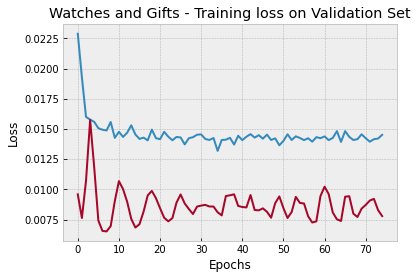

In [89]:
# Store the training in the history variable
history = mm.fit(df_train_x, df_train_y, validation_data=(df_valid_x, df_valid_y), epochs=75, verbose=0)
# See what is stored in the history
#history.history.keys()

#Plot training loss on validation set
loss = history.history["loss"]
vloss = history.history["val_loss"]

plt.plot(range(len(loss)), loss,)
plt.plot(range(len(loss)), vloss)


plt.title("Watches and Gifts - Training loss on Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [90]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_param('window_size', 55)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('num of units', 100)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('num of epochs', 75)
    mlflow.log_param('Google Trends Series','watches,gifts')
    mlflow.log_param('Product Category','Watches and Gifts')
                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: a35b8ccbec5c437fadf0d2e64d27ef56


In [91]:
#metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

### Plot Actuals & Forecasts

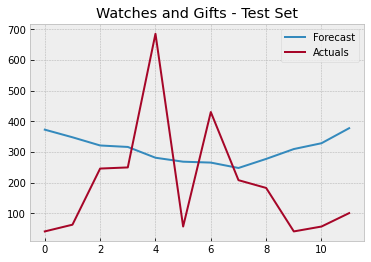

In [92]:
predictions = mm.predict(df_test_x); predictions
predictions = pv_scaler.inverse_transform(predictions);predictions
pv_scaler.inverse_transform(df_test_y).squeeze()

plt.plot(predictions, label='Forecast')
plt.plot(pv_scaler.inverse_transform(df_test_y).squeeze(),label='Actuals')
plt.legend()
plt.title('Watches and Gifts - Test Set')
plt.show()

### Plot Residuals

In [93]:
#Calcaulte Forecast Error
#error = predictions - pv_scaler.inverse_transform(df_test_y).squeeze()
#y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
#plt.scatter( x=y_true.index, y=y_true.residuals)
#plt.title('Bed, Bath and Table Residuals - Test Set ')
#plt.ylabel('Sales R$')
#plt.show()

#Histogram of Residuals
#plt.hist(x=error,density=True)
#plt.title('Histogram of Residuals - Test Set ')
#plt.show()

### Evaluate Performance

In [94]:
metrics.get_metrics(pv_scaler.inverse_transform(df_test_y).squeeze(),predictions, run_id=current_run_id,log=True,param_prefix='test')

wape: 29345.7824346774
rms: 236.38736783346852
r2: -0.6191075484659014
mape: 2.501158186529394


# Product Category 6: Telephony <a name = "telephony"/>

In [95]:
#Filter on product categories (series)
telephony_train = df_train.loc[df_train['product_category_name'] == 'telephony'].copy()
telephony_valid = df_valid.loc[df_valid['product_category_name'] == 'telephony'].copy()
telephony_test = df_test.loc[df_test['product_category_name'] == 'telephony'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

telephony_train.drop(columns, inplace=True, axis=1)
telephony_valid.drop(columns, inplace=True, axis=1)
telephony_test.drop(columns, inplace=True, axis=1)

In [96]:
#Read and process GoogleTrends Series
base_dir_1 = "C:\\Users\\feras\\Documents\\Thesis_2020\\GoogleTrendsSeries\\"

iphone8 = pd.read_csv(os.path.join(base_dir_1,'iphone8.csv')).iloc[1:]
iphonex = pd.read_csv(os.path.join(base_dir_1,'iphonex.csv')).iloc[1:]
galaxyS5 = pd.read_csv(os.path.join(base_dir_1,'SamsungGalaxyS5.csv')).iloc[1:]



iphone8_gt =  utils.make_lag_features(iphone8,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Shopping', 
                                   prefix_name='iphone 8_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})



iphonex_gt =  utils.make_lag_features(iphonex,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Shopping', 
                                   prefix_name='iphone x_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})


galaxyS5_gt =  utils.make_lag_features(galaxyS5,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Shopping', 
                                   prefix_name='Samsung Galaxy S5_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})


# we dont care about the prediction here. Drop category
iphone8_gt.drop(columns='Category: Shopping', inplace=True)
iphone8_gt = iphone8_gt[iphone8_gt.columns[::-1]]

iphonex_gt.drop(columns='Category: Shopping', inplace=True)
iphonex_gt = iphonex_gt[iphonex_gt.columns[::-1]]

galaxyS5_gt.drop(columns='Category: Shopping', inplace=True)
galaxyS5_gt = galaxyS5_gt[galaxyS5_gt.columns[::-1]]


In [97]:
iphone8_gt['order_approved_at'] = pd.to_datetime(iphone8_gt['order_approved_at'])

telephony_train = telephony_train[(telephony_train['order_approved_at'] >= iphone8_gt['order_approved_at'].min()) &
                    (telephony_train['order_approved_at'] < iphone8_gt['order_approved_at'].max())]

telephony_valid = telephony_valid[(telephony_valid['order_approved_at'] >= iphone8_gt['order_approved_at'].min()) &
                    (telephony_valid['order_approved_at'] < iphone8_gt['order_approved_at'].max())]

telephony_test = telephony_test[(telephony_test['order_approved_at'] >= iphone8_gt['order_approved_at'].min()) &
                  (telephony_test['order_approved_at'] < iphone8_gt['order_approved_at'].max())]

iphone8_gt_train = iphone8_gt[(iphone8_gt['order_approved_at'] >= telephony_train['order_approved_at'].min()) &
                                           (iphone8_gt['order_approved_at'] <= telephony_train['order_approved_at'].max())].copy()
iphone8_gt_valid = iphone8_gt[(iphone8_gt['order_approved_at'] >= telephony_valid['order_approved_at'].min()) &
                                           (iphone8_gt['order_approved_at'] <= telephony_valid['order_approved_at'].max())].copy()
iphone8_gt_test = iphone8_gt[(iphone8_gt['order_approved_at'] >= telephony_test['order_approved_at'].min()) &
                                           (iphone8_gt['order_approved_at'] <= telephony_test['order_approved_at'].max())].copy()


iphonex_gt['order_approved_at'] = pd.to_datetime(iphonex_gt['order_approved_at'])

telephony_train = telephony_train[(telephony_train['order_approved_at'] >= iphonex_gt['order_approved_at'].min()) &
                    (telephony_train['order_approved_at'] < iphonex_gt['order_approved_at'].max())]

telephony_valid = telephony_valid[(telephony_valid['order_approved_at'] >= iphonex_gt['order_approved_at'].min()) &
                    (telephony_valid['order_approved_at'] < iphonex_gt['order_approved_at'].max())]

telephony_test = telephony_test[(telephony_test['order_approved_at'] >= iphonex_gt['order_approved_at'].min()) &
                  (telephony_test['order_approved_at'] < iphonex_gt['order_approved_at'].max())]

iphonex_gt_train = iphonex_gt[(iphonex_gt['order_approved_at'] >= telephony_train['order_approved_at'].min()) &
                                           (iphonex_gt['order_approved_at'] <= telephony_train['order_approved_at'].max())].copy()
iphonex_gt_valid = iphonex_gt[(iphonex_gt['order_approved_at'] >= telephony_valid['order_approved_at'].min()) &
                                           (iphonex_gt['order_approved_at'] <= telephony_valid['order_approved_at'].max())].copy()
iphonex_gt_test = iphonex_gt[(iphonex_gt['order_approved_at'] >= telephony_test['order_approved_at'].min()) &
                                           (iphonex_gt['order_approved_at'] <= telephony_test['order_approved_at'].max())].copy()


galaxyS5_gt['order_approved_at'] = pd.to_datetime(galaxyS5_gt['order_approved_at'])

telephony_train = telephony_train[(telephony_train['order_approved_at'] >= galaxyS5_gt['order_approved_at'].min()) &
                    (telephony_train['order_approved_at'] < galaxyS5_gt['order_approved_at'].max())]

telephony_valid = telephony_valid[(telephony_valid['order_approved_at'] >= galaxyS5_gt['order_approved_at'].min()) &
                    (telephony_valid['order_approved_at'] < galaxyS5_gt['order_approved_at'].max())]

telephony_test = telephony_test[(telephony_test['order_approved_at'] >= galaxyS5_gt['order_approved_at'].min()) &
                  (telephony_test['order_approved_at'] < galaxyS5_gt['order_approved_at'].max())]

galaxyS5_gt_train = galaxyS5_gt[(galaxyS5_gt['order_approved_at'] >= telephony_train['order_approved_at'].min()) &
                                           (galaxyS5_gt['order_approved_at'] <= telephony_train['order_approved_at'].max())].copy()
galaxyS5_gt_valid = galaxyS5_gt[(galaxyS5_gt['order_approved_at'] >= telephony_valid['order_approved_at'].min()) &
                                           (galaxyS5_gt['order_approved_at'] <= telephony_valid['order_approved_at'].max())].copy()
galaxyS5_gt_test = galaxyS5_gt[(galaxyS5_gt['order_approved_at'] >= telephony_test['order_approved_at'].min()) &
                                           (galaxyS5_gt['order_approved_at'] <= telephony_test['order_approved_at'].max())].copy()


In [98]:
# Drop unrequired columns
telephony_train = telephony_train.drop(columns=['order_approved_at'])
telephony_valid = telephony_valid.drop(columns=['order_approved_at'])
telephony_test = telephony_test.drop(columns=['order_approved_at'])

iphone8_gt_train = iphone8_gt_train.drop(columns=['order_approved_at'])
iphone8_gt_valid = iphone8_gt_valid.drop(columns=['order_approved_at'])
iphone8_gt_test = iphone8_gt_test.drop(columns=['order_approved_at'])

iphonex_gt_train = iphonex_gt_train.drop(columns=['order_approved_at'])
iphonex_gt_valid = iphonex_gt_valid.drop(columns=['order_approved_at'])
iphonex_gt_test = iphonex_gt_test.drop(columns=['order_approved_at'])

galaxyS5_gt_train = galaxyS5_gt_train.drop(columns=['order_approved_at'])
galaxyS5_gt_valid = galaxyS5_gt_valid.drop(columns=['order_approved_at'])
galaxyS5_gt_test = galaxyS5_gt_test.drop(columns=['order_approved_at'])

In [99]:
# Reshape and convert to numpy arrays
telephony_train = telephony_train.to_numpy().reshape(telephony_train.shape[0], telephony_train.shape[1], 1)
telephony_valid = telephony_valid.to_numpy().reshape(telephony_valid.shape[0], telephony_valid.shape[1], 1)
telephony_test = telephony_test.to_numpy().reshape(telephony_test.shape[0], telephony_test.shape[1], 1)

iphone8_gt_train = iphone8_gt_train.astype(int).to_numpy().reshape(iphone8_gt_train.shape[0], 
                                                                               iphone8_gt_train.shape[1], 1)
iphone8_gt_valid = iphone8_gt_valid.astype(int).to_numpy().reshape(iphone8_gt_valid.shape[0], 
                                                                               iphone8_gt_valid.shape[1], 1)
iphone8_gt_test = iphone8_gt_test.astype(int).to_numpy().reshape(iphone8_gt_test.shape[0], 
                                                                             iphone8_gt_test.shape[1], 1)

iphonex_gt_train = iphonex_gt_train.astype(int).to_numpy().reshape(iphonex_gt_train.shape[0], 
                                                                               iphonex_gt_train.shape[1], 1)
iphonex_gt_valid = iphonex_gt_valid.astype(int).to_numpy().reshape(iphonex_gt_valid.shape[0], 
                                                                               iphonex_gt_valid.shape[1], 1)
iphonex_gt_test = iphonex_gt_test.astype(int).to_numpy().reshape(iphonex_gt_test.shape[0], 
                                                                             iphonex_gt_test.shape[1], 1)

galaxyS5_gt_train = galaxyS5_gt_train.astype(int).to_numpy().reshape(galaxyS5_gt_train.shape[0], 
                                                                               galaxyS5_gt_train.shape[1], 1)
galaxyS5_gt_valid = galaxyS5_gt_valid.astype(int).to_numpy().reshape(galaxyS5_gt_valid.shape[0], 
                                                                               galaxyS5_gt_valid.shape[1], 1)
galaxyS5_gt_test = galaxyS5_gt_test.astype(int).to_numpy().reshape(galaxyS5_gt_test.shape[0], 
                                                                             galaxyS5_gt_test.shape[1], 1)

In [100]:
telephony_train.shape

(88, 56, 1)

In [101]:
# Scaling datasets
pv_scaler = MinMaxScalerDf()
telephony_train = pv_scaler.fit_transform(telephony_train)
telephony_valid = pv_scaler.transform(telephony_valid)
telephony_test = pv_scaler.transform(telephony_test)

gt_scaler = MinMaxScalerDf()
iphone8_gt_train = gt_scaler.fit_transform(iphone8_gt_train)
iphone8_gt_valid = gt_scaler.transform(iphone8_gt_valid)
iphone8_gt_test = gt_scaler.transform(iphone8_gt_test)

iphonex_gt_train = gt_scaler.fit_transform(iphonex_gt_train)
iphonex_gt_valid = gt_scaler.transform(iphonex_gt_valid)
iphonex_gt_test = gt_scaler.transform(iphonex_gt_test)

galaxyS5_gt_train = gt_scaler.fit_transform(galaxyS5_gt_train)
galaxyS5_gt_valid = gt_scaler.transform(galaxyS5_gt_valid)
galaxyS5_gt_test = gt_scaler.transform(galaxyS5_gt_test)


df_train_x = telephony_train[:,:-1,:]
df_train_y = telephony_train[:,-1:,:]
df_valid_x = telephony_valid[:,:-1,:]
df_valid_y = telephony_valid[:,-1:,:]
df_test_x = telephony_test[:,:-1,:]
df_test_y = telephony_test[:,-1:,:]

In [102]:
# Time to concatenate the data together
# This should be commented out if you want to try without google trends, and specify num_series = 1 in the bellow function (a_model)
df_train_x = np.concatenate([df_train_x,iphone8_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,iphone8_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,iphone8_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,iphonex_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,iphonex_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,iphonex_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,galaxyS5_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,galaxyS5_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,galaxyS5_gt_test], axis=2)


In [103]:
df_train_x.shape

(88, 55, 4)

### Define Long Short Term Memory Model

In [104]:
def a_model():
    num_timesteps = 55 # the number of lags in the dataframes
    num_series = 4     # the number of time series, specify 1 if univariate!
    num_units = 100    # the number of hidden units
    
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(num_timesteps, num_series)))
    model.add(Dropout(0.1)) # Prevent overfitting
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [105]:
# Initialize model, specify the training data, to get the input shape
mm = a_model()

In [106]:
mm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               42000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 42,101
Trainable params: 42,101
Non-trainable params: 0
_________________________________________________________________


### Train Model, Report & Visualize Performance on the Validation Set

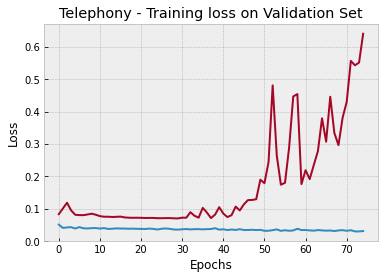

In [107]:
# Store the training in the history variable
history = mm.fit(df_train_x, df_train_y, validation_data=(df_valid_x, df_valid_y), epochs=75, verbose=0)
# See what is stored in the history
#history.history.keys()

#Plot training loss on validation set
loss = history.history["loss"]
vloss = history.history["val_loss"]

plt.plot(range(len(loss)), loss,)
plt.plot(range(len(loss)), vloss)


plt.title("Telephony - Training loss on Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [108]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_param('window_size', 55)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('num of units', 100)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('num of epochs', 75)
    mlflow.log_param('Google Trends Series','iphone 8, iphone x, samsung galaxy s5s')
    mlflow.log_param('Product Category','Telephony')
                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 5648db4615d44fd7a9044d19010b2ba9


In [109]:
#metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True, param_prefix='validation')

### Plot Actuals & Forecasts

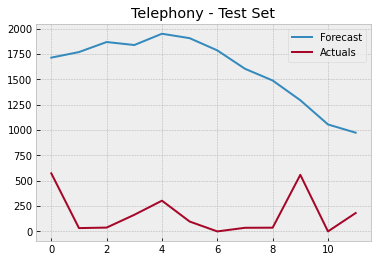

In [110]:
predictions = mm.predict(df_test_x); predictions
predictions = pv_scaler.inverse_transform(predictions);predictions
pv_scaler.inverse_transform(df_test_y).squeeze()

plt.plot(predictions, label='Forecast')
plt.plot(pv_scaler.inverse_transform(df_test_y).squeeze(),label='Actuals')
plt.legend()
plt.title('Telephony - Test Set')
plt.show()

### Plot Residuals

In [111]:
#Calcaulte Forecast Error
#error = predictions - pv_scaler.inverse_transform(df_test_y).squeeze()
#y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
#plt.scatter( x=y_true.index, y=y_true.residuals)
#plt.title('Bed, Bath and Table Residuals - Test Set ')
#plt.ylabel('Sales R$')
#plt.show()

#Histogram of Residuals
#plt.hist(x=error,density=True)
#plt.title('Histogram of Residuals - Test Set ')
#plt.show()

### Evaluate Performance

In [112]:
metrics.get_metrics(pv_scaler.inverse_transform(df_test_y).squeeze(),predictions, run_id=current_run_id,log=True,param_prefix='test')

wape: 124425.74308553005
rms: 1485.9615556656768
r2: -55.855192506513866
mape: 284.90414503140187


# Product Category 7: Housewares <a name = "housewares"/>

In [113]:
#Filter on product categories (series)
housewares_train = df_train.loc[df_train['product_category_name'] == 'housewares'].copy()
housewares_valid = df_valid.loc[df_valid['product_category_name'] == 'housewares'].copy()
housewares_test = df_test.loc[df_test['product_category_name'] == 'housewares'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

housewares_train.drop(columns, inplace=True, axis=1)
housewares_valid.drop(columns, inplace=True, axis=1)
housewares_test.drop(columns, inplace=True, axis=1)

In [114]:
#Read and process GoogleTrends Series
base_dir_1 = "C:\\Users\\feras\\Documents\\Thesis_2020\\GoogleTrendsSeries\\"

cama = pd.read_csv(os.path.join(base_dir_1,'Cama_Shopping.csv')).iloc[1:]
mesa = pd.read_csv(os.path.join(base_dir_1,'Mesa_Shopping.csv')).iloc[1:]
banho = pd.read_csv(os.path.join(base_dir_1,'Banho_Shopping.csv')).iloc[1:]
bed_bath_topic = pd.read_csv(os.path.join(base_dir_1,'Bed_Bath_Topic.csv')).iloc[1:]


cama_gt =  utils.make_lag_features(cama,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Shopping', 
                                   prefix_name='cama_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})

mesa_gt =  utils.make_lag_features(mesa,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Shopping', 
                                   prefix_name='mesa_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})

banho_gt =  utils.make_lag_features(banho,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Shopping', 
                                   prefix_name='banho_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})


bed_bath_topic_gt =  utils.make_lag_features(bed_bath_topic,
                                   config['pre_processing']['window_size'], 
                                   col_name='Category: Bed & Bath', 
                                   prefix_name='bed_bath_topic_gt').dropna().reset_index().rename(columns={'index':'order_approved_at'})


# we dont care about the prediction here. Drop category
cama_gt.drop(columns='Category: Shopping', inplace=True)
cama_gt = cama_gt[cama_gt.columns[::-1]]

mesa_gt.drop(columns='Category: Shopping', inplace=True)
mesa_gt = mesa_gt[mesa_gt.columns[::-1]]

banho_gt.drop(columns='Category: Shopping', inplace=True)
banho_gt = banho_gt[banho_gt.columns[::-1]]

bed_bath_topic_gt.drop(columns='Category: Bed & Bath', inplace=True)
bed_bath_topic_gt = bed_bath_topic_gt[bed_bath_topic_gt.columns[::-1]]

In [115]:
# Filter HistoricalSales and GoogleTrends Series

cama_gt['order_approved_at'] = pd.to_datetime(cama_gt['order_approved_at'])

housewares_train = housewares_train[(housewares_train['order_approved_at'] >= cama_gt['order_approved_at'].min()) &
                    (housewares_train['order_approved_at'] < cama_gt['order_approved_at'].max())]

housewares_valid = housewares_valid[(housewares_valid['order_approved_at'] >= cama_gt['order_approved_at'].min()) &
                    (housewares_valid['order_approved_at'] < cama_gt['order_approved_at'].max())]

housewares_test = housewares_test[(housewares_test['order_approved_at'] >= cama_gt['order_approved_at'].min()) &
                  (housewares_test['order_approved_at'] < cama_gt['order_approved_at'].max())]

cama_gt_train = cama_gt[(cama_gt['order_approved_at'] >= housewares_train['order_approved_at'].min()) &
                                           (cama_gt['order_approved_at'] <= housewares_train['order_approved_at'].max())].copy()
cama_gt_valid = cama_gt[(cama_gt['order_approved_at'] >= housewares_valid['order_approved_at'].min()) &
                                           (cama_gt['order_approved_at'] <= housewares_valid['order_approved_at'].max())].copy()
cama_gt_test = cama_gt[(cama_gt['order_approved_at'] >= housewares_test['order_approved_at'].min()) &
                                           (cama_gt['order_approved_at'] <= housewares_test['order_approved_at'].max())].copy()


mesa_gt['order_approved_at'] = pd.to_datetime(mesa_gt['order_approved_at'])

housewares_train = housewares_train[(housewares_train['order_approved_at'] >= mesa_gt['order_approved_at'].min()) &
                    (housewares_train['order_approved_at'] < mesa_gt['order_approved_at'].max())]

housewares_valid = housewares_valid[(housewares_valid['order_approved_at'] >= mesa_gt['order_approved_at'].min()) &
                    (housewares_valid['order_approved_at'] < mesa_gt['order_approved_at'].max())]

housewares_test = housewares_test[(housewares_test['order_approved_at'] >= mesa_gt['order_approved_at'].min()) &
                  (housewares_test['order_approved_at'] < mesa_gt['order_approved_at'].max())]

mesa_gt_train = mesa_gt[(mesa_gt['order_approved_at'] >= housewares_train['order_approved_at'].min()) &
                                           (mesa_gt['order_approved_at'] <= housewares_train['order_approved_at'].max())].copy()
mesa_gt_valid = mesa_gt[(mesa_gt['order_approved_at'] >= housewares_valid['order_approved_at'].min()) &
                                           (mesa_gt['order_approved_at'] <= housewares_valid['order_approved_at'].max())].copy()
mesa_gt_test = mesa_gt[(mesa_gt['order_approved_at'] >= housewares_test['order_approved_at'].min()) &
                                           (mesa_gt['order_approved_at'] <= housewares_test['order_approved_at'].max())].copy()


banho_gt['order_approved_at'] = pd.to_datetime(banho_gt['order_approved_at'])

housewares_train = housewares_train[(housewares_train['order_approved_at'] >= banho_gt['order_approved_at'].min()) &
                    (housewares_train['order_approved_at'] < banho_gt['order_approved_at'].max())]

housewares_valid = housewares_valid[(housewares_valid['order_approved_at'] >= banho_gt['order_approved_at'].min()) &
                    (housewares_valid['order_approved_at'] < banho_gt['order_approved_at'].max())]

housewares_test = housewares_test[(housewares_test['order_approved_at'] >= banho_gt['order_approved_at'].min()) &
                  (housewares_test['order_approved_at'] < banho_gt['order_approved_at'].max())]

banho_gt_train = banho_gt[(banho_gt['order_approved_at'] >= housewares_train['order_approved_at'].min()) &
                                           (banho_gt['order_approved_at'] <= housewares_train['order_approved_at'].max())].copy()
banho_gt_valid = banho_gt[(banho_gt['order_approved_at'] >= housewares_valid['order_approved_at'].min()) &
                                           (banho_gt['order_approved_at'] <= housewares_valid['order_approved_at'].max())].copy()
banho_gt_test = banho_gt[(banho_gt['order_approved_at'] >= housewares_test['order_approved_at'].min()) &
                                           (banho_gt['order_approved_at'] <= housewares_test['order_approved_at'].max())].copy()

bed_bath_topic_gt['order_approved_at'] = pd.to_datetime(bed_bath_topic_gt['order_approved_at'])

housewares_train = housewares_train[(housewares_train['order_approved_at'] >= bed_bath_topic_gt['order_approved_at'].min()) &
                    (housewares_train['order_approved_at'] < bed_bath_topic_gt['order_approved_at'].max())]

housewares_valid = housewares_valid[(housewares_valid['order_approved_at'] >= bed_bath_topic_gt['order_approved_at'].min()) &
                    (housewares_valid['order_approved_at'] < bed_bath_topic_gt['order_approved_at'].max())]

housewares_test = housewares_test[(housewares_test['order_approved_at'] >= bed_bath_topic_gt['order_approved_at'].min()) &
                  (housewares_test['order_approved_at'] < bed_bath_topic_gt['order_approved_at'].max())]

bed_bath_topic_gt_train = bed_bath_topic_gt[(bed_bath_topic_gt['order_approved_at'] >= housewares_train['order_approved_at'].min()) &
                                           (bed_bath_topic_gt['order_approved_at'] <= housewares_train['order_approved_at'].max())].copy()
bed_bath_topic_gt_valid = bed_bath_topic_gt[(bed_bath_topic_gt['order_approved_at'] >= housewares_valid['order_approved_at'].min()) &
                                           (bed_bath_topic_gt['order_approved_at'] <= housewares_valid['order_approved_at'].max())].copy()
bed_bath_topic_gt_test = bed_bath_topic_gt[(bed_bath_topic_gt['order_approved_at'] >= housewares_test['order_approved_at'].min()) &
                                           (bed_bath_topic_gt['order_approved_at'] <= housewares_test['order_approved_at'].max())].copy()


In [116]:
# Drop unrequired columns
housewares_train = housewares_train.drop(columns=['order_approved_at'])
housewares_valid = housewares_valid.drop(columns=['order_approved_at'])
housewares_test = housewares_test.drop(columns=['order_approved_at'])

cama_gt_train = cama_gt_train.drop(columns=['order_approved_at'])
cama_gt_valid = cama_gt_valid.drop(columns=['order_approved_at'])
cama_gt_test = cama_gt_test.drop(columns=['order_approved_at'])

mesa_gt_train = mesa_gt_train.drop(columns=['order_approved_at'])
mesa_gt_valid = mesa_gt_valid.drop(columns=['order_approved_at'])
mesa_gt_test = mesa_gt_test.drop(columns=['order_approved_at'])

banho_gt_train = banho_gt_train.drop(columns=['order_approved_at'])
banho_gt_valid = banho_gt_valid.drop(columns=['order_approved_at'])
banho_gt_test = banho_gt_test.drop(columns=['order_approved_at'])

bed_bath_topic_gt_train = bed_bath_topic_gt_train.drop(columns=['order_approved_at'])
bed_bath_topic_gt_valid = bed_bath_topic_gt_valid.drop(columns=['order_approved_at'])
bed_bath_topic_gt_test = bed_bath_topic_gt_test.drop(columns=['order_approved_at'])

In [117]:
# Reshape and convert to numpy arrays
housewares_train = housewares_train.to_numpy().reshape(housewares_train.shape[0], housewares_train.shape[1], 1)
housewares_valid = housewares_valid.to_numpy().reshape(housewares_valid.shape[0], housewares_valid.shape[1], 1)
housewares_test = housewares_test.to_numpy().reshape(housewares_test.shape[0], housewares_test.shape[1], 1)

cama_gt_train = cama_gt_train.astype(int).to_numpy().reshape(cama_gt_train.shape[0], 
                                                                               cama_gt_train.shape[1], 1)
cama_gt_valid = cama_gt_valid.astype(int).to_numpy().reshape(cama_gt_valid.shape[0], 
                                                                               cama_gt_valid.shape[1], 1)
cama_gt_test = cama_gt_test.astype(int).to_numpy().reshape(cama_gt_test.shape[0], 
                                                                             cama_gt_test.shape[1], 1)


mesa_gt_train = mesa_gt_train.astype(int).to_numpy().reshape(mesa_gt_train.shape[0], 
                                                                               mesa_gt_train.shape[1], 1)
mesa_gt_valid = mesa_gt_valid.astype(int).to_numpy().reshape(mesa_gt_valid.shape[0], 
                                                                               mesa_gt_valid.shape[1], 1)
mesa_gt_test = mesa_gt_test.astype(int).to_numpy().reshape(mesa_gt_test.shape[0], 
                                                                             mesa_gt_test.shape[1], 1)

banho_gt_train = banho_gt_train.astype(int).to_numpy().reshape(banho_gt_train.shape[0], 
                                                                               banho_gt_train.shape[1], 1)
banho_gt_valid = banho_gt_valid.astype(int).to_numpy().reshape(banho_gt_valid.shape[0], 
                                                                               banho_gt_valid.shape[1], 1)
banho_gt_test = banho_gt_test.astype(int).to_numpy().reshape(banho_gt_test.shape[0], 
                                                                             banho_gt_test.shape[1], 1)

bed_bath_topic_gt_train = bed_bath_topic_gt_train.astype(int).to_numpy().reshape(bed_bath_topic_gt_train.shape[0], 
                                                                               bed_bath_topic_gt_train.shape[1], 1)
bed_bath_topic_gt_valid = bed_bath_topic_gt_valid.astype(int).to_numpy().reshape(bed_bath_topic_gt_valid.shape[0], 
                                                                               bed_bath_topic_gt_valid.shape[1], 1)
bed_bath_topic_gt_test = bed_bath_topic_gt_test.astype(int).to_numpy().reshape(bed_bath_topic_gt_test.shape[0], 
                                                                             bed_bath_topic_gt_test.shape[1], 1)

In [118]:
# Scaling datasets
pv_scaler = MinMaxScalerDf()
housewares_train = pv_scaler.fit_transform(housewares_train)
housewares_valid = pv_scaler.transform(housewares_valid)
housewares_test = pv_scaler.transform(housewares_test)

gt_scaler = MinMaxScalerDf()
cama_gt_train = gt_scaler.fit_transform(cama_gt_train)
cama_gt_valid = gt_scaler.transform(cama_gt_valid)
cama_gt_test = gt_scaler.transform(cama_gt_test)

mesa_gt_train = gt_scaler.fit_transform(mesa_gt_train)
mesa_gt_valid = gt_scaler.transform(mesa_gt_valid)
mesa_gt_test = gt_scaler.transform(mesa_gt_test)

banho_gt_train = gt_scaler.fit_transform(banho_gt_train)
banho_gt_valid = gt_scaler.transform(banho_gt_valid)
banho_gt_test = gt_scaler.transform(banho_gt_test)

bed_bath_topic_gt_train = gt_scaler.fit_transform(bed_bath_topic_gt_train)
bed_bath_topic_gt_valid = gt_scaler.transform(bed_bath_topic_gt_valid)
bed_bath_topic_gt_test = gt_scaler.transform(bed_bath_topic_gt_test)

df_train_x = housewares_train[:,:-1,:]
df_train_y = housewares_train[:,-1:,:]
df_valid_x = housewares_valid[:,:-1,:]
df_valid_y = housewares_valid[:,-1:,:]
df_test_x = housewares_test[:,:-1,:]
df_test_y = housewares_test[:,-1:,:]

In [119]:
# Time to concatenate the data together
# This should be commented out if you want to try without google trends, and specify num_series = 1 in the bellow function (a_model)
df_train_x = np.concatenate([df_train_x,cama_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,cama_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,cama_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,mesa_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,mesa_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,mesa_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,banho_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,banho_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,banho_gt_test], axis=2)

df_train_x = np.concatenate([df_train_x,bed_bath_topic_gt_train], axis=2)
df_valid_x = np.concatenate([df_valid_x,bed_bath_topic_gt_valid], axis=2)
df_test_x = np.concatenate([df_test_x,bed_bath_topic_gt_test], axis=2)

In [120]:
df_train_x.shape

(88, 55, 5)

### Define Long Short Term Memory Model

In [121]:
def a_model():
    num_timesteps = 55 # the number of lags in the dataframes
    num_series = 5     # the number of time series, specify 1 if univariate!
    num_units = 100    # the number of hidden units
    
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(num_timesteps, num_series)))
    model.add(Dropout(0.1)) # Prevent overfitting
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [122]:
# Initialize model, specify the training data, to get the input shape
mm = a_model()

In [123]:
mm.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


### Train Model, Report & Visualize Performance on the Validation Set

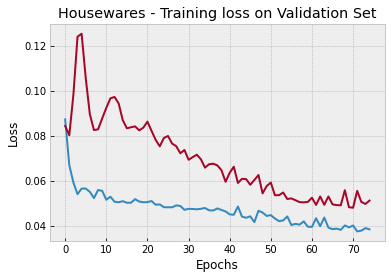

In [124]:
# Store the training in the history variable
history = mm.fit(df_train_x, df_train_y, validation_data=(df_valid_x, df_valid_y), epochs=75, verbose=0)
# See what is stored in the history
#history.history.keys()

#Plot training loss on validation set
loss = history.history["loss"]
vloss = history.history["val_loss"]

plt.plot(range(len(loss)), loss,)
plt.plot(range(len(loss)), vloss)


plt.title("Housewares - Training loss on Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [125]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_param('window_size', 55)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('num of units', 100)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('num of epochs', 75)
    mlflow.log_param('Google Trends Series','cama, mesa, banho, bed and bath - topic')
    mlflow.log_param('Product Category','Housewares')
                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 056471516a2446d4b4cda9feaeec742a


In [126]:
#metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True, param_prefix='validation')

### Plot Actuals & Forecasts

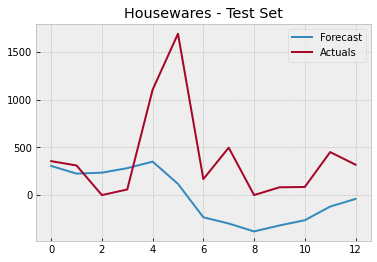

In [127]:
predictions = mm.predict(df_test_x); predictions
predictions = pv_scaler.inverse_transform(predictions);predictions
pv_scaler.inverse_transform(df_test_y).squeeze()

plt.plot(predictions, label='Forecast')
plt.plot(pv_scaler.inverse_transform(df_test_y).squeeze(),label='Actuals')
plt.legend()
plt.title('Housewares - Test Set')
plt.show()

### Plot Residuals

In [128]:
#Calcaulte Forecast Error
#error = predictions - pv_scaler.inverse_transform(df_test_y).squeeze()
#y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
#plt.scatter( x=y_true.index, y=y_true.residuals)
#plt.title('Bed, Bath and Table Residuals - Test Set ')
#plt.ylabel('Sales R$')
#plt.show()

#Histogram of Residuals
#plt.hist(x=error,density=True)
#plt.title('Histogram of Residuals - Test Set ')
#plt.show()

### Evaluate Performance

In [129]:
metrics.get_metrics(pv_scaler.inverse_transform(df_test_y).squeeze(),predictions, run_id=current_run_id,log=True,param_prefix='test')

wape: 263568.80608020094
rms: 609.1905197048233
r2: -0.677337010578972
mape: 38.921524448135216
